A Notebook for training XGBoost models based on clusters of similar cell types. This extends the ak_XGB notebook by using much of the same functions however now extending to the clusters, where training is done on other cell types and then prediction is done on an unseen cell type to see how well the model can generalize.

# Imports

In [1]:
import os
import sys
import time

PARENT_DIR = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.append(PARENT_DIR)

from tqdm import tqdm
from pathlib import Path
import pickle
import json 
import gc

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from ak_data_loader import load_data, get_balanced_data, normalize_features

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import xgboost as xgb
import shap

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import mutual_info_score, confusion_matrix

from scipy.stats import entropy
from itertools import combinations, cycle
from random import sample

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### List of feature names

#### 1 (Current One)

In [3]:
# V3
META_FEATURES = ['gene_length', 'gene_type', 'gene_chr']

ENHANCER_DMR_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-5kb','9mo.2mo.activity.log_ratio.median.0-5kb','9mo.2mo.activity.log_ratio.std.0-5kb','9mo.2mo.activity.log_ratio.max.0-5kb',
                         '9mo.2mo.activity.log_ratio.min.0-5kb','9mo.2mo.activity.log_ratio.count.0-5kb','18mo.2mo.activity.log_ratio.mean.0-5kb','18mo.2mo.activity.log_ratio.median.0-5kb',
                         '18mo.2mo.activity.log_ratio.std.0-5kb','18mo.2mo.activity.log_ratio.max.0-5kb','18mo.2mo.activity.log_ratio.min.0-5kb','18mo.2mo.activity.log_ratio.count.0-5kb',
                         '18mo.9mo.activity.log_ratio.mean.0-5kb','18mo.9mo.activity.log_ratio.median.0-5kb','18mo.9mo.activity.log_ratio.std.0-5kb','18mo.9mo.activity.log_ratio.max.0-5kb',
                         '18mo.9mo.activity.log_ratio.min.0-5kb','18mo.9mo.activity.log_ratio.count.0-5kb','9mo.2mo.contact.log_ratio.mean.0-5kb','9mo.2mo.contact.log_ratio.median.0-5kb',
                         '9mo.2mo.contact.log_ratio.std.0-5kb','9mo.2mo.contact.log_ratio.max.0-5kb','9mo.2mo.contact.log_ratio.min.0-5kb','9mo.2mo.contact.log_ratio.count.0-5kb',
                         '18mo.2mo.contact.log_ratio.mean.0-5kb','18mo.2mo.contact.log_ratio.median.0-5kb','18mo.2mo.contact.log_ratio.std.0-5kb','18mo.2mo.contact.log_ratio.max.0-5kb',
                         '18mo.2mo.contact.log_ratio.min.0-5kb','18mo.2mo.contact.log_ratio.count.0-5kb','18mo.9mo.contact.log_ratio.mean.0-5kb','18mo.9mo.contact.log_ratio.median.0-5kb',
                         '18mo.9mo.contact.log_ratio.std.0-5kb','18mo.9mo.contact.log_ratio.max.0-5kb','18mo.9mo.contact.log_ratio.min.0-5kb','18mo.9mo.contact.log_ratio.count.0-5kb',
                         '9mo.2mo.activity.log_ratio.mean.5kb-20kb','9mo.2mo.activity.log_ratio.median.5kb-20kb','9mo.2mo.activity.log_ratio.std.5kb-20kb','9mo.2mo.activity.log_ratio.max.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.min.5kb-20kb','9mo.2mo.activity.log_ratio.count.5kb-20kb','18mo.2mo.activity.log_ratio.mean.5kb-20kb','18mo.2mo.activity.log_ratio.median.5kb-20kb',
                         '18mo.2mo.activity.log_ratio.std.5kb-20kb','18mo.2mo.activity.log_ratio.max.5kb-20kb','18mo.2mo.activity.log_ratio.min.5kb-20kb','18mo.2mo.activity.log_ratio.count.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.mean.5kb-20kb','18mo.9mo.activity.log_ratio.median.5kb-20kb','18mo.9mo.activity.log_ratio.std.5kb-20kb','18mo.9mo.activity.log_ratio.max.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.min.5kb-20kb','18mo.9mo.activity.log_ratio.count.5kb-20kb','9mo.2mo.contact.log_ratio.mean.5kb-20kb','9mo.2mo.contact.log_ratio.median.5kb-20kb',
                         '9mo.2mo.contact.log_ratio.std.5kb-20kb','9mo.2mo.contact.log_ratio.max.5kb-20kb','9mo.2mo.contact.log_ratio.min.5kb-20kb','9mo.2mo.contact.log_ratio.count.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.mean.5kb-20kb','18mo.2mo.contact.log_ratio.median.5kb-20kb','18mo.2mo.contact.log_ratio.std.5kb-20kb','18mo.2mo.contact.log_ratio.max.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.min.5kb-20kb','18mo.2mo.contact.log_ratio.count.5kb-20kb','18mo.9mo.contact.log_ratio.mean.5kb-20kb','18mo.9mo.contact.log_ratio.median.5kb-20kb',
                         '18mo.9mo.contact.log_ratio.std.5kb-20kb','18mo.9mo.contact.log_ratio.max.5kb-20kb','18mo.9mo.contact.log_ratio.min.5kb-20kb','18mo.9mo.contact.log_ratio.count.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.mean.20kb-5Mb','9mo.2mo.activity.log_ratio.median.20kb-5Mb','9mo.2mo.activity.log_ratio.std.20kb-5Mb','9mo.2mo.activity.log_ratio.max.20kb-5Mb',
                         '9mo.2mo.activity.log_ratio.min.20kb-5Mb','9mo.2mo.activity.log_ratio.count.20kb-5Mb','18mo.2mo.activity.log_ratio.mean.20kb-5Mb','18mo.2mo.activity.log_ratio.median.20kb-5Mb',
                         '18mo.2mo.activity.log_ratio.std.20kb-5Mb','18mo.2mo.activity.log_ratio.max.20kb-5Mb','18mo.2mo.activity.log_ratio.min.20kb-5Mb','18mo.2mo.activity.log_ratio.count.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.mean.20kb-5Mb','18mo.9mo.activity.log_ratio.median.20kb-5Mb','18mo.9mo.activity.log_ratio.std.20kb-5Mb','18mo.9mo.activity.log_ratio.max.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.min.20kb-5Mb','18mo.9mo.activity.log_ratio.count.20kb-5Mb','9mo.2mo.contact.log_ratio.mean.20kb-5Mb','9mo.2mo.contact.log_ratio.median.20kb-5Mb',
                         '9mo.2mo.contact.log_ratio.std.20kb-5Mb','9mo.2mo.contact.log_ratio.max.20kb-5Mb','9mo.2mo.contact.log_ratio.min.20kb-5Mb','9mo.2mo.contact.log_ratio.count.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.mean.20kb-5Mb','18mo.2mo.contact.log_ratio.median.20kb-5Mb','18mo.2mo.contact.log_ratio.std.20kb-5Mb','18mo.2mo.contact.log_ratio.max.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.min.20kb-5Mb','18mo.2mo.contact.log_ratio.count.20kb-5Mb','18mo.9mo.contact.log_ratio.mean.20kb-5Mb','18mo.9mo.contact.log_ratio.median.20kb-5Mb',
                         '18mo.9mo.contact.log_ratio.std.20kb-5Mb','18mo.9mo.contact.log_ratio.max.20kb-5Mb','18mo.9mo.contact.log_ratio.min.20kb-5Mb','18mo.9mo.contact.log_ratio.count.20kb-5Mb','count',]

ENHANCER_PEAK_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-5kb','9mo.2mo.activity.log_ratio.median.0-5kb','9mo.2mo.activity.log_ratio.std.0-5kb','9mo.2mo.activity.log_ratio.max.0-5kb',
                         '9mo.2mo.activity.log_ratio.min.0-5kb','9mo.2mo.activity.log_ratio.count.0-5kb','18mo.2mo.activity.log_ratio.mean.0-5kb','18mo.2mo.activity.log_ratio.median.0-5kb',
                         '18mo.2mo.activity.log_ratio.std.0-5kb','18mo.2mo.activity.log_ratio.max.0-5kb','18mo.2mo.activity.log_ratio.min.0-5kb','18mo.2mo.activity.log_ratio.count.0-5kb',
                         '18mo.9mo.activity.log_ratio.mean.0-5kb','18mo.9mo.activity.log_ratio.median.0-5kb','18mo.9mo.activity.log_ratio.std.0-5kb','18mo.9mo.activity.log_ratio.max.0-5kb',
                         '18mo.9mo.activity.log_ratio.min.0-5kb','18mo.9mo.activity.log_ratio.count.0-5kb','9mo.2mo.contact.log_ratio.mean.0-5kb','9mo.2mo.contact.log_ratio.median.0-5kb',
                         '9mo.2mo.contact.log_ratio.std.0-5kb','9mo.2mo.contact.log_ratio.max.0-5kb','9mo.2mo.contact.log_ratio.min.0-5kb','9mo.2mo.contact.log_ratio.count.0-5kb',
                         '18mo.2mo.contact.log_ratio.mean.0-5kb','18mo.2mo.contact.log_ratio.median.0-5kb','18mo.2mo.contact.log_ratio.std.0-5kb','18mo.2mo.contact.log_ratio.max.0-5kb',
                         '18mo.2mo.contact.log_ratio.min.0-5kb','18mo.2mo.contact.log_ratio.count.0-5kb','18mo.9mo.contact.log_ratio.mean.0-5kb','18mo.9mo.contact.log_ratio.median.0-5kb',
                         '18mo.9mo.contact.log_ratio.std.0-5kb','18mo.9mo.contact.log_ratio.max.0-5kb','18mo.9mo.contact.log_ratio.min.0-5kb','18mo.9mo.contact.log_ratio.count.0-5kb',
                         '9mo.2mo.activity.log_ratio.mean.5kb-20kb','9mo.2mo.activity.log_ratio.median.5kb-20kb','9mo.2mo.activity.log_ratio.std.5kb-20kb','9mo.2mo.activity.log_ratio.max.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.min.5kb-20kb','9mo.2mo.activity.log_ratio.count.5kb-20kb','18mo.2mo.activity.log_ratio.mean.5kb-20kb','18mo.2mo.activity.log_ratio.median.5kb-20kb',
                         '18mo.2mo.activity.log_ratio.std.5kb-20kb','18mo.2mo.activity.log_ratio.max.5kb-20kb','18mo.2mo.activity.log_ratio.min.5kb-20kb','18mo.2mo.activity.log_ratio.count.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.mean.5kb-20kb','18mo.9mo.activity.log_ratio.median.5kb-20kb','18mo.9mo.activity.log_ratio.std.5kb-20kb','18mo.9mo.activity.log_ratio.max.5kb-20kb',
                         '18mo.9mo.activity.log_ratio.min.5kb-20kb','18mo.9mo.activity.log_ratio.count.5kb-20kb','9mo.2mo.contact.log_ratio.mean.5kb-20kb','9mo.2mo.contact.log_ratio.median.5kb-20kb',
                         '9mo.2mo.contact.log_ratio.std.5kb-20kb','9mo.2mo.contact.log_ratio.max.5kb-20kb','9mo.2mo.contact.log_ratio.min.5kb-20kb','9mo.2mo.contact.log_ratio.count.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.mean.5kb-20kb','18mo.2mo.contact.log_ratio.median.5kb-20kb','18mo.2mo.contact.log_ratio.std.5kb-20kb','18mo.2mo.contact.log_ratio.max.5kb-20kb',
                         '18mo.2mo.contact.log_ratio.min.5kb-20kb','18mo.2mo.contact.log_ratio.count.5kb-20kb','18mo.9mo.contact.log_ratio.mean.5kb-20kb','18mo.9mo.contact.log_ratio.median.5kb-20kb',
                         '18mo.9mo.contact.log_ratio.std.5kb-20kb','18mo.9mo.contact.log_ratio.max.5kb-20kb','18mo.9mo.contact.log_ratio.min.5kb-20kb','18mo.9mo.contact.log_ratio.count.5kb-20kb',
                         '9mo.2mo.activity.log_ratio.mean.20kb-5Mb','9mo.2mo.activity.log_ratio.median.20kb-5Mb','9mo.2mo.activity.log_ratio.std.20kb-5Mb','9mo.2mo.activity.log_ratio.max.20kb-5Mb',
                         '9mo.2mo.activity.log_ratio.min.20kb-5Mb','9mo.2mo.activity.log_ratio.count.20kb-5Mb','18mo.2mo.activity.log_ratio.mean.20kb-5Mb','18mo.2mo.activity.log_ratio.median.20kb-5Mb',
                         '18mo.2mo.activity.log_ratio.std.20kb-5Mb','18mo.2mo.activity.log_ratio.max.20kb-5Mb','18mo.2mo.activity.log_ratio.min.20kb-5Mb','18mo.2mo.activity.log_ratio.count.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.mean.20kb-5Mb','18mo.9mo.activity.log_ratio.median.20kb-5Mb','18mo.9mo.activity.log_ratio.std.20kb-5Mb','18mo.9mo.activity.log_ratio.max.20kb-5Mb',
                         '18mo.9mo.activity.log_ratio.min.20kb-5Mb','18mo.9mo.activity.log_ratio.count.20kb-5Mb','9mo.2mo.contact.log_ratio.mean.20kb-5Mb','9mo.2mo.contact.log_ratio.median.20kb-5Mb',
                         '9mo.2mo.contact.log_ratio.std.20kb-5Mb','9mo.2mo.contact.log_ratio.max.20kb-5Mb','9mo.2mo.contact.log_ratio.min.20kb-5Mb','9mo.2mo.contact.log_ratio.count.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.mean.20kb-5Mb','18mo.2mo.contact.log_ratio.median.20kb-5Mb','18mo.2mo.contact.log_ratio.std.20kb-5Mb','18mo.2mo.contact.log_ratio.max.20kb-5Mb',
                         '18mo.2mo.contact.log_ratio.min.20kb-5Mb','18mo.2mo.contact.log_ratio.count.20kb-5Mb','18mo.9mo.contact.log_ratio.mean.20kb-5Mb','18mo.9mo.contact.log_ratio.median.20kb-5Mb',
                         '18mo.9mo.contact.log_ratio.std.20kb-5Mb','18mo.9mo.contact.log_ratio.max.20kb-5Mb','18mo.9mo.contact.log_ratio.min.20kb-5Mb','18mo.9mo.contact.log_ratio.count.20kb-5Mb','count',]

DMR_FEATURES = ['size.log2', 'rel_pos', '9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio', 'distance.log2', 'count']
DAR_FEATURES = ['rel_pos', '9mo.2mo.log_ratio', '18mo.9mo.log_ratio','18mo.2mo.log_ratio', 'count']

GENEBODY_MCG_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']
GENEBODY_MCH_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']

ATAC_FEATURES = ['9mo.2mo.log_ratio.mean', '18mo.9mo.log_ratio.mean','18mo.2mo.log_ratio.mean', 'log2_distance.mean',
                 '9mo.2mo.log_ratio.std', '18mo.9mo.log_ratio.std','18mo.2mo.log_ratio.std', 'log2_distance.std', '9mo.2mo.log_ratio.max',
                 '18mo.9mo.log_ratio.max', '18mo.2mo.log_ratio.max', 'log2_distance.max','9mo.2mo.log_ratio.min', '18mo.9mo.log_ratio.min',
                 '18mo.2mo.log_ratio.min', 'log2_distance.min', 'count']

LOOP_FEATURES = ['Qanova.mean', 'Qanova.median', 'Qanova.std', 'Qanova.max','Qanova.min', 'Tanova.mean', 'Tanova.median', 'Tanova.std',
                 'Tanova.max', 'Tanova.min', '9mo.2mo.Q.mean', '9mo.2mo.Q.median','9mo.2mo.Q.std', '9mo.2mo.Q.max', '9mo.2mo.Q.min', '18mo.9mo.Q.mean',
                 '18mo.9mo.Q.median', '18mo.9mo.Q.std', '18mo.9mo.Q.max','18mo.9mo.Q.min', '18mo.2mo.Q.mean', '18mo.2mo.Q.median',
                 '18mo.2mo.Q.std', '18mo.2mo.Q.max', '18mo.2mo.Q.min', '9mo.2mo.T.mean','9mo.2mo.T.median', '9mo.2mo.T.std', '9mo.2mo.T.max', '9mo.2mo.T.min',
                 '18mo.9mo.T.mean', '18mo.9mo.T.median', '18mo.9mo.T.std','18mo.9mo.T.max', '18mo.9mo.T.min', '18mo.2mo.T.mean',
                 '18mo.2mo.T.median', '18mo.2mo.T.std', '18mo.2mo.T.max','18mo.2mo.T.min', 'loop_size.log.mean', 'loop_size.log.median',
                 'loop_size.log.std', 'loop_size.log.max', 'loop_size.log.min','min_distance.log.mean', 'min_distance.log.median',
                 'min_distance.log.std', 'min_distance.log.max', 'min_distance.log.min','count']

DATA_FEATURE_NAMES = {'meta' : META_FEATURES,
                      'enhancer_DMR' : ENHANCER_DMR_FEATURES,
                      'enhancer_peak' : ENHANCER_DMR_FEATURES,
                      'DAR' : DAR_FEATURES, 
                      'DMR' : DMR_FEATURES,
                      'loops' : LOOP_FEATURES,
                      'mcg_genebody' : GENEBODY_MCG_FEATURES, 
                      'mch_genebody' : GENEBODY_MCH_FEATURES, 
                      'atac' : ATAC_FEATURES}

# Pipeline

## Functions

In [15]:
def load_data_wrapper(ct, DATA_FEATURE_NAMES, y_val:str = "DEG", _testing_type:str = "imbalanced", rna_type:str = "luisa", 
              data_filepath:str = f"../data/v2", na_cutoff=0.5): 
    """
    For loading in the data and preparring the train / test dataframes
    """
    data = load_data(y_val = y_val, ct=ct, rna_type=rna_type, data_filepath=data_filepath, DATA_FEATURE_NAMES=DATA_FEATURE_NAMES, na_cutoff=na_cutoff)

    # For balanced testing (Regular Cross Entropy Loss)
    if _testing_type == "balanced":
        X_balanced, y_balanced = get_balanced_data(data, method='balanced', y_val="DEG")
    elif _testing_type == "balanced_2": 
        X_balanced, y_balanced = get_balanced_data(data, method=None, y_val="DEG")
    # For imbalanced training (loss function must accomodate for this)
    elif _testing_type == "imbalanced":
        X_balanced = data['X']
        y_balanced = data['y']
    else: 
        raise("error")
    
    FEATURE_TYPES = list(X_balanced.keys())
    # for k, v in X_balanced.items():
    #         print(k, len(v))

    return X_balanced, y_balanced, FEATURE_TYPES

def min_max_norm(train_data, test_data): 
    train_norm = ( train_data - train_data.min() ) / (train_data.max() - train_data.min())
    test_norm = ( test_data - test_data.min() ) / (test_data.max() - test_data.min())
    return train_norm, test_norm

def zscore_norm(train_data, test_data): 
    train_norm = (train_data - train_data.mean()) / (train_data.std())
    test_norm = (test_data - test_data.mean()) / (test_data.std())
    return train_norm, test_norm    

def aggregate_modalities(X_balanced, FEATURE_TYPES): 
    # Concatenating all the feature types
    for i, _feat in enumerate(FEATURE_TYPES): 
        X_feat = X_balanced[_feat].copy()
        X_feat.columns = [f"{c}.{_feat}" for c in X_feat.columns]
        if i == 0: 
            X = X_feat.copy()
        else: 
            X = X.merge(X_feat, left_on = 'gene_name', right_on='gene_name')
    return X

def aggregate_cell_types(X_dict, Y_dict, CELL_LIST): 
    """
    """
    X_df = []
    Y_df = []
    # Iterate over cell types
    for i, _ct in enumerate(CELL_LIST): 
        # Handle X values
        try: 
            X_ct = X_dict[_ct].copy()
        except: 
            continue
        X_ct.index = [f"{c}.{_ct}" for c in X_ct.index]
        X_df.append(X_ct)
        # Handle y values
        Y_ct = Y_dict[_ct].copy()
        Y_ct.index = [f"{c}.{_ct}" for c in Y_ct.index]
        Y_df.append(Y_ct)
    # Aggregate
    X_df = pd.concat(X_df).fillna(0)
    Y_df = pd.concat(Y_df)
    return X_df, Y_df

def split(X, Y, random_state:int=13): 
    
    # Split by numerical or non non-numerical columns
    X_str = X[X.dtypes[X.dtypes=='object'].index]
    X_str = X_str.astype("category")
    X_numerical = X[X.dtypes[X.dtypes!='object'].index]
    
    # Not working yet with the categorical gene chr or gene type
    # X = X_str.merge(X_numerical, left_on='gene_name', right_on='gene_name')
    X = X_numerical
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    return X, Y, kf

def split_and_normalize(X, y_balanced, test_size:float = 0.2, random_state:int=13): 
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_balanced, test_size = 0.2, random_state = random_state, stratify=y_balanced)
    
    # Split by numerical or non non-numerical columns
    X_train_str = X_train[X_train.dtypes[X_train.dtypes=='object'].index]
    X_train_numerical = X_train[X_train.dtypes[X_train.dtypes!='object'].index]
    
    X_test_str = X_test[X_test.dtypes[X_test.dtypes=='object'].index]
    X_test_numerical = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
        
    # X_train_numerical, X_test_numerical = min_max_norm(X_train_numerical, X_test_numerical)
    # X_train, X_test = zscore_norm(X_train, X_test)
    
    # Not working yet with the categorical gene chr or gene type
    # X_train = X_train_str.merge(X_train_numerical, left_on='gene_name', right_on='gene_name')
    # X_test = X_test_str.merge(X_test_numerical, left_on='gene_name', right_on='gene_name')
    
    X_train = X_train_numerical
    X_test = X_test_numerical
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    return (X_train, X_test, y_train, y_test, kf)

In [11]:
# Defining the Search Space
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1), 
        'gamma' : hp.uniform('gamma', 0.5, 5), 
        'reg_alpha' : hp.quniform('reg_alpha', 1, 40, 1), 
        'reg_lambda': hp.uniform('reg_lambda', 0, 1), 
        'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
        'seed' : 13
        }

def objective(space): 

    # Doing the kfold split for the hyperparameter tuning part
    accuracies = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)): 
        df_train = X_train.iloc[train_idx]
        df_test = X_train.iloc[test_idx]
        y_tr = y_train.iloc[train_idx]
        y_te = y_train.iloc[test_idx]
        
        sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)
        # sample_weights, sw_te = AK_sample_weights(y_tr, y_te)
        
        xgb_mod = xgb.XGBClassifier(
            n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']),                         
            gamma = space['gamma'], reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'], 
            seed=space['seed'] )
    
        
        # evaluation = [(X_train, y_train, X_test, y_test)]
        xgb_mod = xgb_mod.fit(df_train, y_tr, sample_weight=sample_weights)
        
        pred = xgb_mod.predict(df_test)
        # train_pred = xgb_mod.predict(df_train)
        # if len(np.unique(train_pred)) == 1: 
        #     print("constant training prediction")
        max_gain = information_gain(y_te, y_te)
        gain_ratio = information_gain(y_te, pred) / max_gain
        # print("Information Gain Ratio: %.4f bits" % (gain_ratio))
        bal_accuracy = balanced_accuracy_score(y_te, pred) #, sample_weight=sw_te)
        # accuracies.append(bal_accuracy)    
        accuracies.append(gain_ratio*0.2 + 0.8*bal_accuracy)  
    res_acc = np.mean(accuracies)
    return {'loss' : -res_acc, 'status' : STATUS_OK}
    
def train_model(X_train, y_train, objective, space, num_evals): 
    
    # Performing the hyperparameter search
    trials = Trials()
    best_hyperparams = fmin(fn = objective, space = space, 
                            algo = tpe.suggest, 
                            max_evals = num_evals, trials = trials)

    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    # sample_weights, _ = AK_sample_weights(y_train, y_test)

    # Training a model based on the best hyperparameters 
    xgb_mod = xgb.XGBClassifier(max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
                               n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
                                reg_lambda = best_hyperparams['reg_lambda'], seed = 13)
    # train on the sub training
    xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)
    
    return xgb_mod

In [12]:
def rank_ordering_from_shap(shap_values, X_df:pd.DataFrame, classes:list = ['down', 'non', 'up']): 
    """
    Return rank ordering as well as mean of the absolute values of each of the features
    """
    for i, c in enumerate(classes):
        df_temp = pd.DataFrame(shap_values[:, :, i].values, 
                               columns=X_df.columns, 
                               index=X_df.index)

        df_rank = df_temp.abs().mean().sort_values(ascending=False)
        df_rank = pd.DataFrame(df_rank).reset_index().reset_index().set_index('index')
        df_rank.columns=[f'rank.{c}', f'abs_mean_shap.{c}']
        df_rank[f'rank.{c}'] += 1
        if i == 0: 
            ranked_order = df_rank
        else: 
            ranked_order = ranked_order.merge(df_rank, left_on='index', right_on='index')
    return ranked_order

def generate_ct_features(df_rank, num_downsample:int|None = None): 
    
    if num_downsample is not None: 
        samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'rank.down'])
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'rank.non'], left_on='index', right_on = 'index', how='outer')
        samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'rank.up'], left_on='index', right_on = 'index', how='outer')
        df_rank = samp_rank.copy()
        del samp_rank

    features = df_rank.index

    DATA_FEATURE_NAMES = {'meta' : [],'enhancer_DMR' : [],'enhancer_peak' : [],
                          'DAR' : [], 'DMR' : [],'loops' : [],'mcg_genebody' : [], 
                          'mch_genebody' : [], 'atac' : []}
            
    for _feat in features: 
        split_feat = _feat.split(".")
        DATA_FEATURE_NAMES[split_feat[-1]].append(".".join(split_feat[:-1]))
    return DATA_FEATURE_NAMES

In [13]:
def information_gain(labels, preds): 
    start_entropy = entropy(pd.DataFrame(y_test).value_counts(), base=2)
    ccf = confusion_matrix(labels, preds)
    conditional_entropy = (entropy(ccf, base=2, axis=0) * (ccf.sum(axis=0) / ccf.sum())).sum()
    return start_entropy - conditional_entropy 

def evaluation_metrics(X_train, X_test, y_train, y_test):
    # For overall training
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)

    train_acc = accuracy_score(y_train, y_train_preds)
    test_acc = accuracy_score(y_test, y_test_preds)
    train_b_acc = balanced_accuracy_score(y_train, y_train_preds)
    test_b_acc = balanced_accuracy_score(y_test, y_test_preds)
    print("Train XGB Accuracy: %.2f%%" % (train_acc*100))
    print("Train Balanced XGB Accuracy: %.2f%%" %(train_b_acc*100))
    print("Test XGB Accuracy: %.2f%%" % (test_acc*100))
    print("Test Balanced XGB Accuracy: %.2f%%" %(test_b_acc*100))
    return (train_acc, test_acc, train_b_acc, test_b_acc)

def ccf_metrics(X_train, X_test, y_train, y_test): 
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)
    
    ccf_test = confusion_matrix(y_test, y_test_preds, normalize='true')
    ccf_train = confusion_matrix(y_train, y_train_preds, normalize='true')
    fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[0])
    sns.heatmap(ccf_train, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[1])
    
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Label")
    ax[0].set_title("Test")
    ax[1].set_xlabel("Prediction")
    ax[1].set_ylabel("Label")
    ax[1].set_title("Train")
    return fig, ax

def micro_PRC(y_test, y_score): 
    Y = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = Y.shape[1]

    precision, recall, _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision = average_precision_score(Y, y_score, average="micro")
    return precision, recall, average_precision

In [14]:
def AK_sample_weights(y, te): 
    n_classes = len(np.unique(y))
    n_samples = len(y)
    weights = n_samples / (n_classes * np.bincount(y))
    order = np.argsort(weights)
    diff = (weights[order[-1]] - weights[order[-2]]) / 2
    weights[order[-1]] -= diff
    ret_dict = {}
    for i, w in enumerate(weights):
        ret_dict[i] = w
    samp_weights = compute_sample_weight(class_weight=ret_dict, y=y)
    samp_weights_test = compute_sample_weight(class_weight=ret_dict, y=te)
    return samp_weights, samp_weights_test

## Defined Clusters
Training on defined clusters either from the correlation analysis or from expected cell types

In [9]:
cell_clusters =  {"CTX_Glut" : ['L23_IT_CTX_Glut','L6_CT_CTX_Glut','L6_IT_CTX_Glut','L5_ET_CTX_Glut',], 
                  "Hipo_Glut" : ['DG_Glut','CA1-ProS_Glut','CA3_Glut',],
                  "NN" : ['Astro-TE_NN','Oligo_NN','OPC_NN'], 
                  "IT_CTX_Hipo_Glut" : ['L23_IT_CTX_Glut','L6_IT_CTX_Glut','CA1-ProS_Glut','CA3_Glut',],
                  "CTX_Hipo_Glut" : ['L23_IT_CTX_Glut','L6_IT_CTX_Glut','CA1-ProS_Glut',
                                     'CA3_Glut','L6_CT_CTX_Glut','L5_ET_CTX_Glut'],
                  "NN_DG_Glut" : ['Astro-TE_NN','Oligo_NN','OPC_NN', 'DG_Glut'],
                 }

### Run

In [18]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v3"
p_na_cutoff=0.5
random_state = 13
SAMPLE_FEATURES = False
num_evals=20

CTX_Glut
L23_IT_CTX_Glut
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
0 : 205
100%|██████████| 20/20 [00:57<00:00,  2.86s/trial, best loss: -0.41776700822051555]
L23_IT_CTX_Glut
IGR: 0.074; Balanced Accuracy: 0.583; Acuracy: 0.575; micro AP: 0.555; micro AUROC: 0.780


 99%|===================| 27643/28059 [00:53<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
1 : 169
100%|██████████| 20/20 [00:50<00:00,  2.50s/trial, best loss: -0.41690764402189784]
L23_IT_CTX_Glut
IGR: 0.075; Balanced Accuracy: 0.577; Acuracy: 0.572; micro AP: 0.552; micro AUROC: 0.779


 98%|===================| 27618/28059 [00:44<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
2 : 138
100%|██████████| 20/20 [00:40<00:00,  2.01s/trial, best loss: -0.4038812045252264]
L23_IT_CTX_Glut
IGR: 0.075; Balanced Accuracy: 0.605; Acuracy: 0.545; micro AP: 0.525; micro AUROC: 0.761


 99%|===================| 27875/28059 [00:37<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
3 : 114
100%|██████████| 20/20 [00:32<00:00,  1.63s/trial, best loss: -0.4162234094343047]
L23_IT_CTX_Glut
IGR: 0.068; Balanced Accuracy: 0.591; Acuracy: 0.541; micro AP: 0.523; micro AUROC: 0.759


 98%|===================| 27417/28059 [00:36<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
4 : 97
100%|██████████| 20/20 [00:29<00:00,  1.46s/trial, best loss: -0.41251282321441585]
L23_IT_CTX_Glut
IGR: 0.075; Balanced Accuracy: 0.604; Acuracy: 0.547; micro AP: 0.526; micro AUROC: 0.763


 99%|===================| 27750/28059 [00:27<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
5 : 86
100%|██████████| 20/20 [00:26<00:00,  1.33s/trial, best loss: -0.42739969466888433]
L23_IT_CTX_Glut
IGR: 0.073; Balanced Accuracy: 0.584; Acuracy: 0.588; micro AP: 0.569; micro AUROC: 0.789


 99%|===================| 27813/28059 [00:55<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
6 : 68
100%|██████████| 20/20 [00:20<00:00,  1.02s/trial, best loss: -0.42498164028521684]
L23_IT_CTX_Glut
IGR: 0.075; Balanced Accuracy: 0.591; Acuracy: 0.570; micro AP: 0.552; micro AUROC: 0.776


 98%|===================| 27490/28059 [00:47<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
7 : 58
100%|██████████| 20/20 [00:21<00:00,  1.07s/trial, best loss: -0.4202272773766194]
L23_IT_CTX_Glut
IGR: 0.075; Balanced Accuracy: 0.605; Acuracy: 0.536; micro AP: 0.505; micro AUROC: 0.748


 99%|===================| 27789/28059 [00:30<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
8 : 52
100%|██████████| 20/20 [00:20<00:00,  1.01s/trial, best loss: -0.4094167604839402]
L23_IT_CTX_Glut
IGR: 0.072; Balanced Accuracy: 0.589; Acuracy: 0.555; micro AP: 0.535; micro AUROC: 0.766


 98%|===================| 27546/28059 [00:39<00:00]        

zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2152
0    1901
2     251
Name: count, dtype: int64
9 : 46
100%|██████████| 20/20 [00:17<00:00,  1.17trial/s, best loss: -0.42287014501253817]
L23_IT_CTX_Glut
IGR: 0.071; Balanced Accuracy: 0.596; Acuracy: 0.533; micro AP: 0.507; micro AUROC: 0.750


 99%|===================| 27838/28059 [00:35<00:00]        

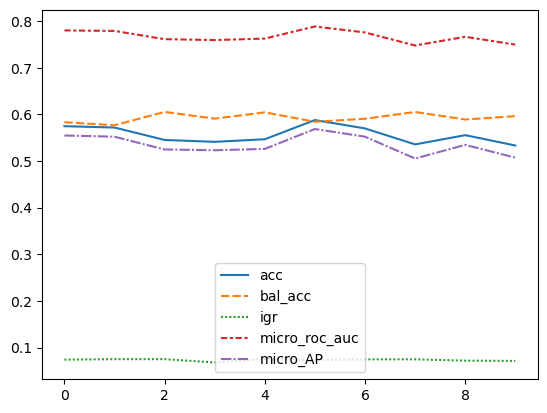

L6_CT_CTX_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
0 : 221
100%|██████████| 20/20 [00:55<00:00,  2.77s/trial, best loss: -0.3689195473742456]
L6_CT_CTX_Glut
IGR: 0.092; Balanced Accuracy: 0.639; Acuracy: 0.578; micro AP: 0.566; micro AUROC: 0.786


 99%|===================| 27791/28068 [00:55<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
1 : 172
100%|██████████| 20/20 [00:44<00:00,  2.21s/trial, best loss: -0.3612809610786146]
L6_CT_CTX_Glut
IGR: 0.090; Balanced Accuracy: 0.644; Acuracy: 0.580; micro AP: 0.562; micro AUROC: 0.783


 98%|===================| 27383/28068 [00:40<00:01]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
2 : 141
100%|██████████| 20/20 [00:38<00:00,  1.92s/trial, best loss: -0.36337002101990656]
L6_CT_CTX_Glut
IGR: 0.092; Balanced Accuracy: 0.646; Acuracy: 0.564; micro AP: 0.548; micro AUROC: 0.773


100%|===================| 27998/28068 [00:38<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
3 : 112
100%|██████████| 20/20 [00:31<00:00,  1.59s/trial, best loss: -0.37499484238251446]
L6_CT_CTX_Glut
IGR: 0.104; Balanced Accuracy: 0.660; Acuracy: 0.588; micro AP: 0.584; micro AUROC: 0.792


100%|===================| 27969/28068 [00:53<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
4 : 94
100%|██████████| 20/20 [00:30<00:00,  1.51s/trial, best loss: -0.3668162269077445]
L6_CT_CTX_Glut
IGR: 0.092; Balanced Accuracy: 0.643; Acuracy: 0.581; micro AP: 0.567; micro AUROC: 0.786


 99%|===================| 27758/28068 [00:32<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
5 : 80
100%|██████████| 20/20 [00:27<00:00,  1.35s/trial, best loss: -0.3728906684495555] 
L6_CT_CTX_Glut
IGR: 0.096; Balanced Accuracy: 0.643; Acuracy: 0.589; micro AP: 0.594; micro AUROC: 0.798


 99%|===================| 27849/28068 [01:06<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
6 : 68
100%|██████████| 20/20 [00:22<00:00,  1.13s/trial, best loss: -0.38120215718668343]
L6_CT_CTX_Glut
IGR: 0.093; Balanced Accuracy: 0.633; Acuracy: 0.577; micro AP: 0.569; micro AUROC: 0.785


 99%|===================| 27804/28068 [00:37<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
7 : 61
100%|██████████| 20/20 [00:23<00:00,  1.15s/trial, best loss: -0.381138464804594] 
L6_CT_CTX_Glut
IGR: 0.096; Balanced Accuracy: 0.644; Acuracy: 0.596; micro AP: 0.596; micro AUROC: 0.800


100%|===================| 28034/28068 [00:45<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
8 : 53
100%|██████████| 20/20 [00:20<00:00,  1.04s/trial, best loss: -0.3780459194848017]
L6_CT_CTX_Glut
IGR: 0.105; Balanced Accuracy: 0.643; Acuracy: 0.630; micro AP: 0.647; micro AUROC: 0.826


100%|===================| 27952/28068 [01:20<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 8692, non-zero: 491
DEG
1    2245
0    1932
2     313
Name: count, dtype: int64
9 : 48
100%|██████████| 20/20 [00:19<00:00,  1.04trial/s, best loss: -0.38464475310171903]
L6_CT_CTX_Glut
IGR: 0.097; Balanced Accuracy: 0.648; Acuracy: 0.583; micro AP: 0.572; micro AUROC: 0.787


 98%|===================| 27397/28068 [00:33<00:00]        

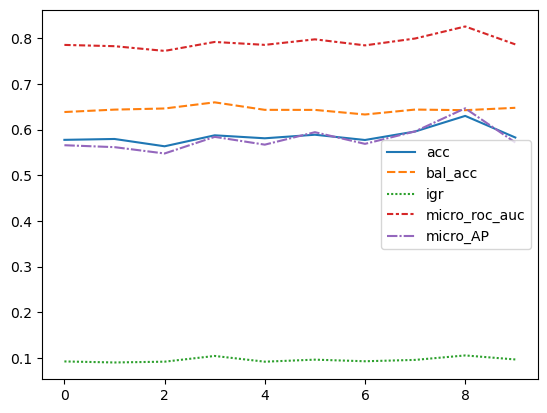

L6_IT_CTX_Glut
zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
0 : 205
100%|██████████| 20/20 [01:08<00:00,  3.45s/trial, best loss: 0.6926892519992112]
L6_IT_CTX_Glut
IGR: 0.082; Balanced Accuracy: 0.666; Acuracy: 0.581; micro AP: 0.533; micro AUROC: 0.776


 99%|===================| 27594/27759 [01:02<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
1 : 162
100%|██████████| 20/20 [00:58<00:00,  2.94s/trial, best loss: 0.6918195792021191]
L6_IT_CTX_Glut
IGR: 0.090; Balanced Accuracy: 0.661; Acuracy: 0.649; micro AP: 0.620; micro AUROC: 0.826


100%|===================| 27653/27759 [01:40<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
2 : 133
100%|██████████| 20/20 [00:55<00:00,  2.79s/trial, best loss: 0.6912292693834428]
L6_IT_CTX_Glut
IGR: 0.088; Balanced Accuracy: 0.667; Acuracy: 0.602; micro AP: 0.574; micro AUROC: 0.799


 99%|===================| 27424/27759 [01:18<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
3 : 111
100%|██████████| 20/20 [00:48<00:00,  2.42s/trial, best loss: 0.6962471708401352]
L6_IT_CTX_Glut
IGR: 0.085; Balanced Accuracy: 0.667; Acuracy: 0.606; micro AP: 0.582; micro AUROC: 0.802


 98%|===================| 27134/27759 [00:44<00:01]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
4 : 92
100%|██████████| 20/20 [00:56<00:00,  2.83s/trial, best loss: 0.6886874654900732]
L6_IT_CTX_Glut
IGR: 0.092; Balanced Accuracy: 0.679; Acuracy: 0.604; micro AP: 0.590; micro AUROC: 0.805


100%|===================| 27672/27759 [01:03<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
5 : 76
100%|██████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: 0.6917609073435715]
L6_IT_CTX_Glut
IGR: 0.085; Balanced Accuracy: 0.661; Acuracy: 0.606; micro AP: 0.576; micro AUROC: 0.799


100%|===================| 27740/27759 [01:05<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
6 : 63
100%|██████████| 20/20 [00:37<00:00,  1.85s/trial, best loss: 0.675424678863978]
L6_IT_CTX_Glut
IGR: 0.092; Balanced Accuracy: 0.679; Acuracy: 0.599; micro AP: 0.593; micro AUROC: 0.804


 99%|===================| 27528/27759 [01:20<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
7 : 58
100%|██████████| 20/20 [00:37<00:00,  1.88s/trial, best loss: 0.693265785164398]
L6_IT_CTX_Glut
IGR: 0.085; Balanced Accuracy: 0.653; Acuracy: 0.576; micro AP: 0.531; micro AUROC: 0.771


 99%|===================| 27578/27759 [00:48<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
8 : 48
100%|██████████| 20/20 [00:23<00:00,  1.19s/trial, best loss: 0.6662723122127651]
L6_IT_CTX_Glut
IGR: 0.081; Balanced Accuracy: 0.654; Acuracy: 0.599; micro AP: 0.574; micro AUROC: 0.796


 99%|===================| 27382/27759 [01:06<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    3526
0    3104
2     422
Name: count, dtype: int64
9 : 45
100%|██████████| 20/20 [00:24<00:00,  1.21s/trial, best loss: 0.6716138175721909]
L6_IT_CTX_Glut
IGR: 0.082; Balanced Accuracy: 0.659; Acuracy: 0.590; micro AP: 0.546; micro AUROC: 0.780


 99%|===================| 27526/27759 [01:05<00:00]        

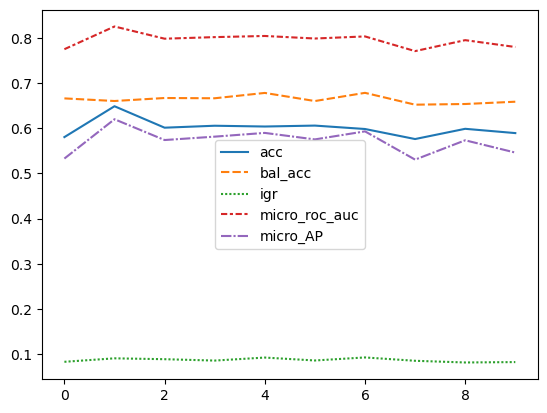

L5_ET_CTX_Glut
zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [00:58<00:00,  2.94s/trial, best loss: -0.0425384588695622] 
L5_ET_CTX_Glut
IGR: 0.091; Balanced Accuracy: 0.651; Acuracy: 0.538; micro AP: 0.513; micro AUROC: 0.748


100%|===================| 27424/27549 [00:55<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
1 : 150
100%|██████████| 20/20 [00:48<00:00,  2.45s/trial, best loss: -0.0464189246303842] 
L5_ET_CTX_Glut
IGR: 0.084; Balanced Accuracy: 0.641; Acuracy: 0.496; micro AP: 0.474; micro AUROC: 0.719


 99%|===================| 27304/27549 [00:35<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
2 : 128
100%|██████████| 20/20 [00:40<00:00,  2.00s/trial, best loss: -0.05127828758462614]
L5_ET_CTX_Glut
IGR: 0.084; Balanced Accuracy: 0.646; Acuracy: 0.498; micro AP: 0.478; micro AUROC: 0.720


 99%|===================| 27355/27549 [00:50<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
3 : 106
100%|██████████| 20/20 [00:37<00:00,  1.90s/trial, best loss: -0.04868665858226391]
L5_ET_CTX_Glut
IGR: 0.076; Balanced Accuracy: 0.635; Acuracy: 0.489; micro AP: 0.456; micro AUROC: 0.706


 99%|===================| 27362/27549 [00:36<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
4 : 89
100%|██████████| 20/20 [00:32<00:00,  1.63s/trial, best loss: -0.056583536942839296]
L5_ET_CTX_Glut
IGR: 0.089; Balanced Accuracy: 0.656; Acuracy: 0.510; micro AP: 0.472; micro AUROC: 0.720


 99%|===================| 27152/27549 [00:36<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
5 : 77
100%|██████████| 20/20 [00:28<00:00,  1.41s/trial, best loss: -0.05970862775928667]
L5_ET_CTX_Glut
IGR: 0.081; Balanced Accuracy: 0.644; Acuracy: 0.450; micro AP: 0.438; micro AUROC: 0.688


 98%|===================| 27062/27549 [00:36<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
6 : 67
100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.06412450820970922]
L5_ET_CTX_Glut
IGR: 0.086; Balanced Accuracy: 0.647; Acuracy: 0.521; micro AP: 0.499; micro AUROC: 0.740


 99%|===================| 27153/27549 [01:02<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
7 : 62
100%|██████████| 20/20 [00:44<00:00,  2.21s/trial, best loss: -0.05715592790050509]
L5_ET_CTX_Glut
IGR: 0.091; Balanced Accuracy: 0.659; Acuracy: 0.498; micro AP: 0.472; micro AUROC: 0.718


100%|===================| 27442/27549 [00:54<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
8 : 58
100%|██████████| 20/20 [00:34<00:00,  1.74s/trial, best loss: -0.05098047603177528] 
L5_ET_CTX_Glut
IGR: 0.092; Balanced Accuracy: 0.664; Acuracy: 0.506; micro AP: 0.490; micro AUROC: 0.728


 99%|===================| 27367/27549 [00:56<00:00]        

zero: 7789, non-zero: 1564
zero: 7885, non-zero: 1471
zero: 9063, non-zero: 190
DEG
1    3225
0    2849
2     376
Name: count, dtype: int64
9 : 51
100%|██████████| 20/20 [00:37<00:00,  1.86s/trial, best loss: -0.05622675670179552]
L5_ET_CTX_Glut
IGR: 0.088; Balanced Accuracy: 0.647; Acuracy: 0.509; micro AP: 0.493; micro AUROC: 0.732


 99%|===================| 27273/27549 [01:03<00:00]        

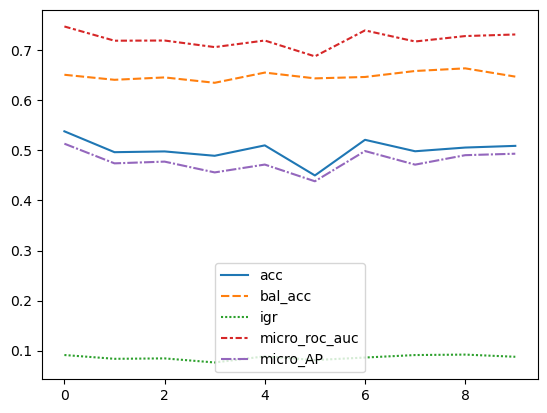

Hipo_Glut
DG_Glut
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [00:57<00:00,  2.86s/trial, best loss: -0.44027951745414]  
DG_Glut
IGR: 0.020; Balanced Accuracy: 0.472; Acuracy: 0.533; micro AP: 0.514; micro AUROC: 0.709


 99%|===================| 24629/24930 [00:27<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
1 : 141
100%|██████████| 20/20 [00:43<00:00,  2.17s/trial, best loss: -0.4408703347671198] 
DG_Glut
IGR: 0.019; Balanced Accuracy: 0.474; Acuracy: 0.523; micro AP: 0.510; micro AUROC: 0.702


100%|===================| 24819/24930 [00:43<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
2 : 104
100%|██████████| 20/20 [00:38<00:00,  1.91s/trial, best loss: -0.4514614517175531]
DG_Glut
IGR: 0.020; Balanced Accuracy: 0.477; Acuracy: 0.523; micro AP: 0.510; micro AUROC: 0.701


 97%|=================== | 24070/24930 [00:25<00:00]       

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
3 : 86
100%|██████████| 20/20 [00:34<00:00,  1.73s/trial, best loss: -0.4543938111379071]
DG_Glut
IGR: 0.017; Balanced Accuracy: 0.462; Acuracy: 0.543; micro AP: 0.519; micro AUROC: 0.703


 97%|=================== | 24271/24930 [00:31<00:00]       

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
4 : 67
100%|██████████| 20/20 [00:24<00:00,  1.22s/trial, best loss: -0.447232800312331] 
DG_Glut
IGR: 0.020; Balanced Accuracy: 0.459; Acuracy: 0.570; micro AP: 0.551; micro AUROC: 0.729


 99%|===================| 24588/24930 [00:56<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
5 : 57
100%|██████████| 20/20 [00:21<00:00,  1.10s/trial, best loss: -0.4458445878921249] 
DG_Glut
IGR: 0.025; Balanced Accuracy: 0.486; Acuracy: 0.546; micro AP: 0.527; micro AUROC: 0.704


 99%|===================| 24772/24930 [00:45<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
6 : 46
100%|██████████| 20/20 [00:26<00:00,  1.31s/trial, best loss: -0.4444749652979153]
DG_Glut
IGR: 0.021; Balanced Accuracy: 0.477; Acuracy: 0.525; micro AP: 0.502; micro AUROC: 0.699


 96%|=================== | 24015/24930 [00:26<00:00]       

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
7 : 39
100%|██████████| 20/20 [00:28<00:00,  1.41s/trial, best loss: -0.439717746636718]
DG_Glut
IGR: 0.021; Balanced Accuracy: 0.481; Acuracy: 0.496; micro AP: 0.485; micro AUROC: 0.672


 99%|===================| 24755/24930 [01:35<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
8 : 34
100%|██████████| 20/20 [00:33<00:00,  1.66s/trial, best loss: -0.4510507039920353]
DG_Glut
IGR: 0.019; Balanced Accuracy: 0.470; Acuracy: 0.487; micro AP: 0.461; micro AUROC: 0.663


 98%|===================| 24549/24930 [00:44<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2080
2    1459
0     621
Name: count, dtype: int64
9 : 27
100%|██████████| 20/20 [00:25<00:00,  1.27s/trial, best loss: -0.4354846862072047] 
DG_Glut
IGR: 0.017; Balanced Accuracy: 0.465; Acuracy: 0.470; micro AP: 0.460; micro AUROC: 0.657


100%|===================| 24873/24930 [01:07<00:00]        

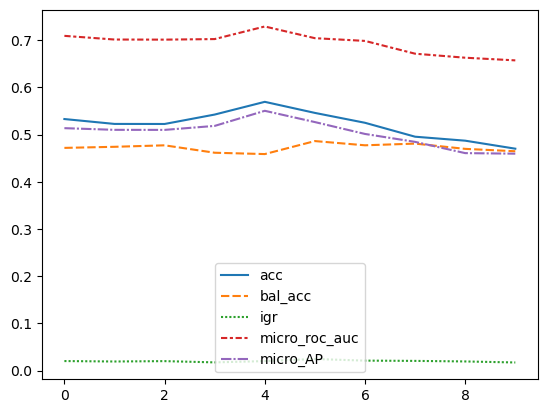

CA1-ProS_Glut
zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [01:02<00:00,  3.12s/trial, best loss: -0.38940645116095685]
CA1-ProS_Glut
IGR: 0.050; Balanced Accuracy: 0.503; Acuracy: 0.483; micro AP: 0.437; micro AUROC: 0.695


 99%|===================| 24130/24447 [00:45<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
1 : 148
100%|██████████| 20/20 [00:59<00:00,  3.00s/trial, best loss: -0.38162555603384246]
CA1-ProS_Glut
IGR: 0.050; Balanced Accuracy: 0.506; Acuracy: 0.542; micro AP: 0.483; micro AUROC: 0.733


100%|===================| 24346/24447 [01:24<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
2 : 113
100%|██████████| 20/20 [00:47<00:00,  2.37s/trial, best loss: -0.3870865922450266]
CA1-ProS_Glut
IGR: 0.049; Balanced Accuracy: 0.497; Acuracy: 0.505; micro AP: 0.447; micro AUROC: 0.706


 99%|===================| 24307/24447 [00:53<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
3 : 88
100%|██████████| 20/20 [00:42<00:00,  2.11s/trial, best loss: -0.3852012832474649]
CA1-ProS_Glut
IGR: 0.043; Balanced Accuracy: 0.495; Acuracy: 0.472; micro AP: 0.420; micro AUROC: 0.674


100%|===================| 24408/24447 [01:07<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
4 : 73
100%|██████████| 20/20 [00:36<00:00,  1.82s/trial, best loss: -0.3911715668302168]
CA1-ProS_Glut
IGR: 0.053; Balanced Accuracy: 0.514; Acuracy: 0.452; micro AP: 0.409; micro AUROC: 0.664


 99%|===================| 24088/24447 [00:53<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
5 : 59
100%|██████████| 20/20 [00:34<00:00,  1.72s/trial, best loss: -0.38105850583048095]
CA1-ProS_Glut
IGR: 0.055; Balanced Accuracy: 0.511; Acuracy: 0.505; micro AP: 0.445; micro AUROC: 0.702


 99%|===================| 24262/24447 [00:59<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
6 : 50
100%|██████████| 20/20 [00:23<00:00,  1.19s/trial, best loss: -0.3822559412246386] 
CA1-ProS_Glut
IGR: 0.055; Balanced Accuracy: 0.517; Acuracy: 0.499; micro AP: 0.443; micro AUROC: 0.701


 99%|===================| 24301/24447 [00:56<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
7 : 42
100%|██████████| 20/20 [00:22<00:00,  1.14s/trial, best loss: -0.38542947908256064]
CA1-ProS_Glut
IGR: 0.053; Balanced Accuracy: 0.514; Acuracy: 0.513; micro AP: 0.463; micro AUROC: 0.712


 99%|===================| 24181/24447 [01:21<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
8 : 38
100%|██████████| 20/20 [00:20<00:00,  1.01s/trial, best loss: -0.38620505804354077]
CA1-ProS_Glut
IGR: 0.056; Balanced Accuracy: 0.520; Acuracy: 0.526; micro AP: 0.477; micro AUROC: 0.724


 99%|===================| 24258/24447 [01:45<00:00]        

zero: 5461, non-zero: 2849
zero: 7816, non-zero: 861
DEG
1    3710
0    2813
2     897
Name: count, dtype: int64
9 : 31
100%|██████████| 20/20 [00:29<00:00,  1.45s/trial, best loss: -0.38637999268258494]
CA1-ProS_Glut
IGR: 0.048; Balanced Accuracy: 0.506; Acuracy: 0.482; micro AP: 0.435; micro AUROC: 0.691


100%|===================| 24445/24447 [01:16<00:00]        

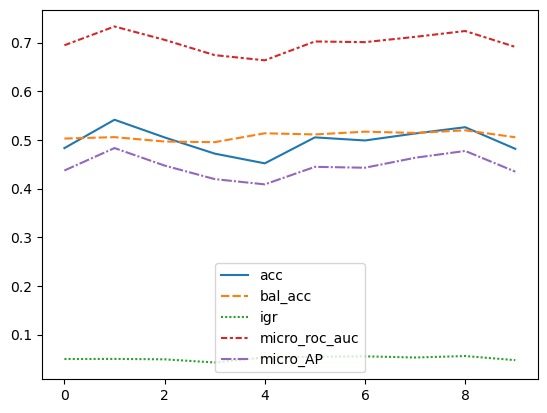

CA3_Glut
zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
0 : 173
100%|██████████| 20/20 [01:10<00:00,  3.54s/trial, best loss: -0.2488511628090852]
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.490; Acuracy: 0.286; micro AP: 0.315; micro AUROC: 0.528


 99%|===================| 25853/26031 [01:30<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
1 : 128
100%|██████████| 20/20 [01:07<00:00,  3.40s/trial, best loss: -0.23745160369760754]
CA3_Glut
IGR: 0.032; Balanced Accuracy: 0.489; Acuracy: 0.307; micro AP: 0.326; micro AUROC: 0.551


100%|===================| 25994/26031 [01:43<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
2 : 97
100%|██████████| 20/20 [00:53<00:00,  2.66s/trial, best loss: -0.24471241772648353]
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.490; Acuracy: 0.302; micro AP: 0.318; micro AUROC: 0.533


 99%|===================| 25761/26031 [01:06<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
3 : 77
100%|██████████| 20/20 [01:03<00:00,  3.16s/trial, best loss: -0.245632331670395] 
CA3_Glut
IGR: 0.032; Balanced Accuracy: 0.490; Acuracy: 0.290; micro AP: 0.321; micro AUROC: 0.540


 99%|===================| 25697/26031 [01:07<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
4 : 64
100%|██████████| 20/20 [00:46<00:00,  2.31s/trial, best loss: -0.24171729157906735]
CA3_Glut
IGR: 0.037; Balanced Accuracy: 0.497; Acuracy: 0.299; micro AP: 0.323; micro AUROC: 0.547


 99%|===================| 25881/26031 [01:27<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
5 : 50
100%|██████████| 20/20 [00:35<00:00,  1.79s/trial, best loss: -0.23621643117600324]
CA3_Glut
IGR: 0.036; Balanced Accuracy: 0.502; Acuracy: 0.303; micro AP: 0.332; micro AUROC: 0.568


 99%|===================| 25808/26031 [01:30<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
6 : 41
100%|██████████| 20/20 [00:33<00:00,  1.68s/trial, best loss: -0.23536478333200206]
CA3_Glut
IGR: 0.028; Balanced Accuracy: 0.480; Acuracy: 0.265; micro AP: 0.309; micro AUROC: 0.517


 99%|===================| 25648/26031 [00:52<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
7 : 34
100%|██████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: -0.23860420766730622]
CA3_Glut
IGR: 0.035; Balanced Accuracy: 0.506; Acuracy: 0.272; micro AP: 0.316; micro AUROC: 0.532


100%|===================| 25914/26031 [00:50<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
8 : 31
100%|██████████| 20/20 [00:27<00:00,  1.39s/trial, best loss: -0.23422129772069394]
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.494; Acuracy: 0.284; micro AP: 0.320; micro AUROC: 0.540


100%|===================| 25995/26031 [01:26<00:00]        

zero: 5461, non-zero: 2849
zero: 6930, non-zero: 1219
DEG
1    4068
0    3126
2     942
Name: count, dtype: int64
9 : 27
100%|██████████| 20/20 [00:19<00:00,  1.01trial/s, best loss: -0.2280800836142851] 
CA3_Glut
IGR: 0.038; Balanced Accuracy: 0.519; Acuracy: 0.263; micro AP: 0.315; micro AUROC: 0.530


100%|===================| 26025/26031 [00:41<00:00]        

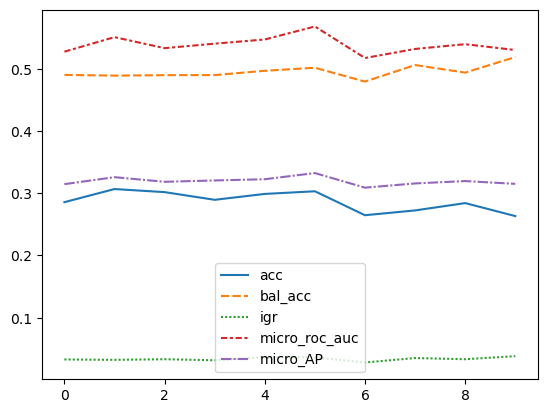

NN
Astro-TE_NN
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
0 : 219
100%|██████████| 20/20 [00:49<00:00,  2.46s/trial, best loss: 0.3279846344241829] 
Astro-TE_NN
IGR: 0.106; Balanced Accuracy: 0.669; Acuracy: 0.474; micro AP: 0.421; micro AUROC: 0.690


 99%|===================| 19592/19887 [00:34<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
1 : 174
100%|██████████| 20/20 [00:43<00:00,  2.19s/trial, best loss: 0.3431483211498536]
Astro-TE_NN
IGR: 0.091; Balanced Accuracy: 0.641; Acuracy: 0.488; micro AP: 0.423; micro AUROC: 0.692


 99%|===================| 19758/19887 [00:42<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
2 : 142
100%|██████████| 20/20 [00:38<00:00,  1.92s/trial, best loss: 0.3302434140442219]
Astro-TE_NN
IGR: 0.097; Balanced Accuracy: 0.651; Acuracy: 0.476; micro AP: 0.417; micro AUROC: 0.687


 99%|===================| 19757/19887 [00:38<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
3 : 118
100%|██████████| 20/20 [00:33<00:00,  1.70s/trial, best loss: 0.32664085705788143]
Astro-TE_NN
IGR: 0.107; Balanced Accuracy: 0.665; Acuracy: 0.480; micro AP: 0.419; micro AUROC: 0.690


 98%|===================| 19588/19887 [00:17<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
4 : 91
100%|██████████| 20/20 [00:26<00:00,  1.30s/trial, best loss: 0.3372859901033617]
Astro-TE_NN
IGR: 0.112; Balanced Accuracy: 0.669; Acuracy: 0.537; micro AP: 0.453; micro AUROC: 0.720


 98%|===================| 19523/19887 [00:38<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
5 : 72
100%|██████████| 20/20 [00:24<00:00,  1.24s/trial, best loss: 0.3066839460582256] 
Astro-TE_NN
IGR: 0.110; Balanced Accuracy: 0.670; Acuracy: 0.498; micro AP: 0.426; micro AUROC: 0.693


 98%|===================| 19508/19887 [00:51<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
6 : 59
100%|██████████| 20/20 [00:20<00:00,  1.04s/trial, best loss: 0.31026944850132854]
Astro-TE_NN
IGR: 0.114; Balanced Accuracy: 0.681; Acuracy: 0.501; micro AP: 0.439; micro AUROC: 0.706


 99%|===================| 19656/19887 [00:53<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
7 : 50
100%|██████████| 20/20 [00:17<00:00,  1.13trial/s, best loss: 0.31935019944329623]
Astro-TE_NN
IGR: 0.099; Balanced Accuracy: 0.651; Acuracy: 0.445; micro AP: 0.399; micro AUROC: 0.665


 97%|=================== | 19374/19887 [00:15<00:00]       

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
8 : 42
100%|██████████| 20/20 [00:16<00:00,  1.21trial/s, best loss: 0.3375545951556552]
Astro-TE_NN
IGR: 0.109; Balanced Accuracy: 0.665; Acuracy: 0.549; micro AP: 0.477; micro AUROC: 0.737


100%|===================| 19789/19887 [00:48<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1707
0    1011
2     696
Name: count, dtype: int64
9 : 36
100%|██████████| 20/20 [00:14<00:00,  1.40trial/s, best loss: 0.3278974632541062]
Astro-TE_NN
IGR: 0.091; Balanced Accuracy: 0.639; Acuracy: 0.451; micro AP: 0.396; micro AUROC: 0.664


 99%|===================| 19716/19887 [00:16<00:00]        

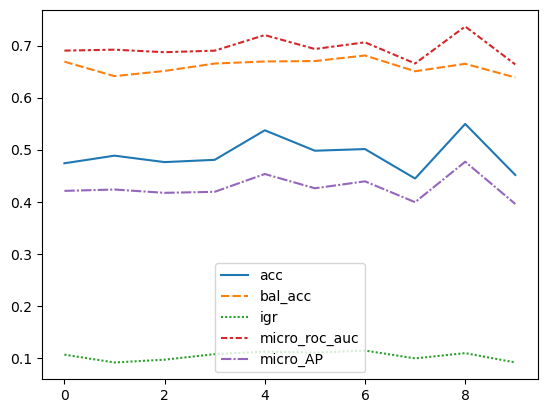

Oligo_NN
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
0 : 219
100%|██████████| 20/20 [00:37<00:00,  1.90s/trial, best loss: -0.5424760366940279]
Oligo_NN
IGR: 0.087; Balanced Accuracy: 0.533; Acuracy: 0.600; micro AP: 0.619; micro AUROC: 0.789


 99%|===================| 16416/16638 [00:12<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
1 : 127
100%|██████████| 20/20 [00:24<00:00,  1.21s/trial, best loss: -0.5544891485455091]
Oligo_NN
IGR: 0.091; Balanced Accuracy: 0.542; Acuracy: 0.597; micro AP: 0.610; micro AUROC: 0.784


 92%|==================  | 15236/16638 [00:12<00:01]       

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
2 : 90
100%|██████████| 20/20 [00:19<00:00,  1.02trial/s, best loss: -0.567504242028406]
Oligo_NN
IGR: 0.074; Balanced Accuracy: 0.504; Acuracy: 0.540; micro AP: 0.549; micro AUROC: 0.739
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
3 : 61
100%|██████████| 20/20 [00:15<00:00,  1.28trial/s, best loss: -0.5620946366765306]
Oligo_NN
IGR: 0.093; Balanced Accuracy: 0.543; Acuracy: 0.613; micro AP: 0.609; micro AUROC: 0.789
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
4 : 46
100%|██████████| 20/20 [00:12<00:00,  1.56trial/s, best loss: -0.5651098539936874]
Oligo_NN
IGR: 0.086; Balanced Accuracy: 0.539; Acuracy: 0.590; micro AP: 0.610; micro AUROC: 0.788
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int6

 94%|=================== | 15648/16638 [00:14<00:00]       

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
6 : 31
100%|██████████| 20/20 [00:11<00:00,  1.69trial/s, best loss: -0.5672486921619609]
Oligo_NN
IGR: 0.084; Balanced Accuracy: 0.526; Acuracy: 0.596; micro AP: 0.631; micro AUROC: 0.785
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
7 : 27
100%|██████████| 20/20 [00:09<00:00,  2.07trial/s, best loss: -0.5519412219827912]
Oligo_NN
IGR: 0.091; Balanced Accuracy: 0.541; Acuracy: 0.613; micro AP: 0.630; micro AUROC: 0.799


 97%|=================== | 16100/16638 [00:17<00:00]       

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
8 : 21
100%|██████████| 20/20 [00:09<00:00,  2.14trial/s, best loss: -0.5495335585459279]
Oligo_NN
IGR: 0.090; Balanced Accuracy: 0.540; Acuracy: 0.611; micro AP: 0.603; micro AUROC: 0.787
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
DEG
1    363
2    183
0    180
Name: count, dtype: int64
9 : 18
100%|██████████| 20/20 [00:08<00:00,  2.36trial/s, best loss: -0.5686866023843402]
Oligo_NN
IGR: 0.101; Balanced Accuracy: 0.559; Acuracy: 0.610; micro AP: 0.640; micro AUROC: 0.801


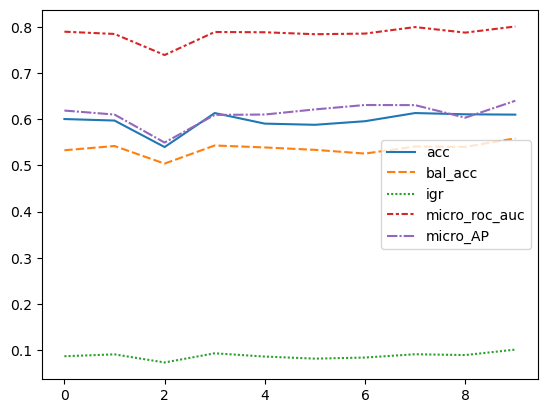

OPC_NN
zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [00:42<00:00,  2.11s/trial, best loss: 0.4177503164689969] 
OPC_NN
IGR: 0.079; Balanced Accuracy: 0.567; Acuracy: 0.392; micro AP: 0.387; micro AUROC: 0.642


 99%|===================| 19107/19296 [00:49<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
1 : 144
100%|██████████| 20/20 [00:34<00:00,  1.71s/trial, best loss: 0.4130187087537426] 
OPC_NN
IGR: 0.104; Balanced Accuracy: 0.572; Acuracy: 0.398; micro AP: 0.363; micro AUROC: 0.616


 97%|=================== | 18710/19296 [00:13<00:00]       

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
2 : 107
100%|██████████| 20/20 [00:29<00:00,  1.47s/trial, best loss: 0.3953653957882807] 
OPC_NN
IGR: 0.098; Balanced Accuracy: 0.601; Acuracy: 0.369; micro AP: 0.350; micro AUROC: 0.592


 98%|===================| 18942/19296 [00:28<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
3 : 85
100%|██████████| 20/20 [00:26<00:00,  1.31s/trial, best loss: 0.40351780852344976]
OPC_NN
IGR: 0.103; Balanced Accuracy: 0.570; Acuracy: 0.368; micro AP: 0.344; micro AUROC: 0.584


 98%|===================| 18822/19296 [00:19<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
4 : 69
100%|██████████| 20/20 [00:21<00:00,  1.08s/trial, best loss: 0.3762842780060608]
OPC_NN
IGR: 0.107; Balanced Accuracy: 0.595; Acuracy: 0.399; micro AP: 0.364; micro AUROC: 0.608


100%|===================| 19292/19296 [00:25<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
5 : 56
100%|██████████| 20/20 [00:17<00:00,  1.12trial/s, best loss: 0.40488731597058736]
OPC_NN
IGR: 0.099; Balanced Accuracy: 0.575; Acuracy: 0.392; micro AP: 0.364; micro AUROC: 0.613


 95%|=================== | 18417/19296 [00:21<00:01]       

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
6 : 50
100%|██████████| 20/20 [00:16<00:00,  1.20trial/s, best loss: 0.39046491517568394]
OPC_NN
IGR: 0.105; Balanced Accuracy: 0.562; Acuracy: 0.368; micro AP: 0.340; micro AUROC: 0.577


 99%|===================| 19156/19296 [00:19<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
7 : 40
100%|██████████| 20/20 [00:15<00:00,  1.27trial/s, best loss: 0.38796650216526307]
OPC_NN
IGR: 0.106; Balanced Accuracy: 0.579; Acuracy: 0.401; micro AP: 0.363; micro AUROC: 0.610


 97%|=================== | 18812/19296 [00:24<00:00]       

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
8 : 34
100%|██████████| 20/20 [00:14<00:00,  1.35trial/s, best loss: 0.39742688156157874]
OPC_NN
IGR: 0.111; Balanced Accuracy: 0.610; Acuracy: 0.413; micro AP: 0.380; micro AUROC: 0.635


 99%|===================| 19137/19296 [00:23<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
DEG
1    1730
0    1065
2     665
Name: count, dtype: int64
9 : 27
100%|██████████| 20/20 [00:14<00:00,  1.37trial/s, best loss: 0.41057908143066674]
OPC_NN
IGR: 0.086; Balanced Accuracy: 0.555; Acuracy: 0.307; micro AP: 0.326; micro AUROC: 0.547


 98%|===================| 18826/19296 [00:40<00:00]        

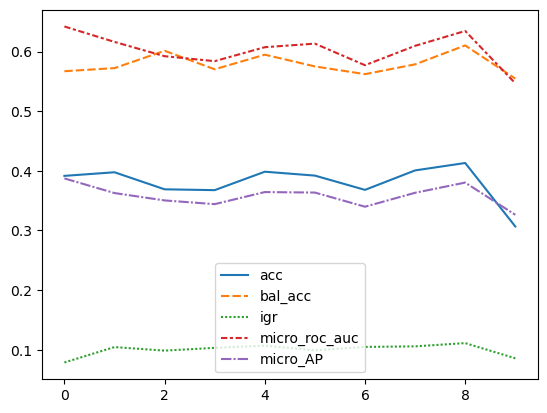

IT_CTX_Hipo_Glut
L23_IT_CTX_Glut
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
0 : 197
100%|██████████| 20/20 [00:44<00:00,  2.25s/trial, best loss: -0.335087761892892] 
L23_IT_CTX_Glut
IGR: 0.018; Balanced Accuracy: 0.427; Acuracy: 0.453; micro AP: 0.436; micro AUROC: 0.686


 99%|===================| 27784/28059 [01:06<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
1 : 155
100%|██████████| 20/20 [00:41<00:00,  2.08s/trial, best loss: -0.3368451772278513] 
L23_IT_CTX_Glut
IGR: 0.024; Balanced Accuracy: 0.450; Acuracy: 0.462; micro AP: 0.450; micro AUROC: 0.695


 99%|===================| 27865/28059 [00:56<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
2 : 126
100%|██████████| 20/20 [00:36<00:00,  1.80s/trial, best loss: -0.34097524711899224]
L23_IT_CTX_Glut
IGR: 0.026; Balanced Accuracy: 0.460; Acuracy: 0.511; micro AP: 0.494; micro AUROC: 0.723


 99%|===================| 27823/28059 [01:41<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
3 : 104
100%|██████████| 20/20 [00:31<00:00,  1.56s/trial, best loss: -0.34989761492145877]
L23_IT_CTX_Glut
IGR: 0.020; Balanced Accuracy: 0.439; Acuracy: 0.436; micro AP: 0.412; micro AUROC: 0.661


 98%|===================| 27601/28059 [00:39<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
4 : 82
100%|██████████| 20/20 [00:26<00:00,  1.32s/trial, best loss: -0.3489471571266113]
L23_IT_CTX_Glut
IGR: 0.023; Balanced Accuracy: 0.429; Acuracy: 0.458; micro AP: 0.439; micro AUROC: 0.684


 99%|===================| 27828/28059 [00:48<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
5 : 66
100%|██████████| 20/20 [00:23<00:00,  1.16s/trial, best loss: -0.3457841828707795] 
L23_IT_CTX_Glut
IGR: 0.019; Balanced Accuracy: 0.420; Acuracy: 0.460; micro AP: 0.460; micro AUROC: 0.703


 98%|===================| 27460/28059 [00:45<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
6 : 56
100%|██████████| 20/20 [00:21<00:00,  1.09s/trial, best loss: -0.33868814837307293]
L23_IT_CTX_Glut
IGR: 0.014; Balanced Accuracy: 0.408; Acuracy: 0.429; micro AP: 0.408; micro AUROC: 0.661


 99%|===================| 27804/28059 [00:24<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
7 : 47
100%|██████████| 20/20 [00:19<00:00,  1.01trial/s, best loss: -0.3433007583799865]
L23_IT_CTX_Glut
IGR: 0.020; Balanced Accuracy: 0.439; Acuracy: 0.468; micro AP: 0.443; micro AUROC: 0.691


 99%|===================| 27779/28059 [00:58<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
8 : 39
100%|██████████| 20/20 [00:17<00:00,  1.13trial/s, best loss: -0.33807685475523375]
L23_IT_CTX_Glut
IGR: 0.015; Balanced Accuracy: 0.418; Acuracy: 0.482; micro AP: 0.438; micro AUROC: 0.689


 98%|===================| 27483/28059 [00:32<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    2270
2    1491
0     779
Name: count, dtype: int64
9 : 35
100%|██████████| 20/20 [00:18<00:00,  1.10trial/s, best loss: -0.33623457861401435]
L23_IT_CTX_Glut
IGR: 0.020; Balanced Accuracy: 0.442; Acuracy: 0.434; micro AP: 0.413; micro AUROC: 0.663


 99%|===================| 27888/28059 [00:52<00:00]        

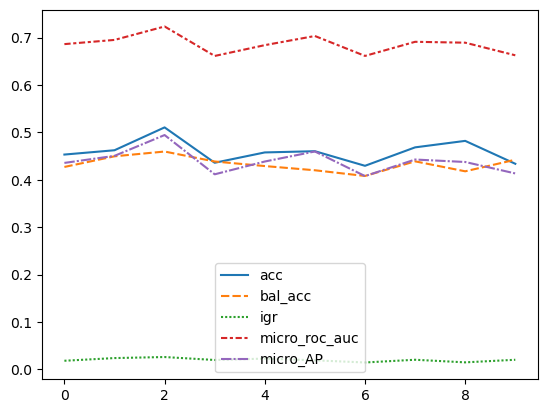

L6_IT_CTX_Glut
zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [00:55<00:00,  2.77s/trial, best loss: 0.896886510600391] 
L6_IT_CTX_Glut
IGR: 0.039; Balanced Accuracy: 0.530; Acuracy: 0.594; micro AP: 0.576; micro AUROC: 0.809


 99%|===================| 27578/27759 [01:15<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
1 : 147
100%|██████████| 20/20 [00:45<00:00,  2.25s/trial, best loss: 0.887362055944705] 
L6_IT_CTX_Glut
IGR: 0.033; Balanced Accuracy: 0.507; Acuracy: 0.624; micro AP: 0.612; micro AUROC: 0.829


 99%|===================| 27427/27759 [00:49<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
2 : 120
100%|██████████| 20/20 [00:38<00:00,  1.92s/trial, best loss: 0.8926869695971611]
L6_IT_CTX_Glut
IGR: 0.046; Balanced Accuracy: 0.554; Acuracy: 0.629; micro AP: 0.618; micro AUROC: 0.830


 99%|===================| 27553/27759 [01:28<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
3 : 98
100%|██████████| 20/20 [00:38<00:00,  1.92s/trial, best loss: 0.8765965666504272]
L6_IT_CTX_Glut
IGR: 0.045; Balanced Accuracy: 0.544; Acuracy: 0.622; micro AP: 0.610; micro AUROC: 0.822


100%|===================| 27741/27759 [01:54<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
4 : 85
100%|██████████| 20/20 [00:32<00:00,  1.64s/trial, best loss: 0.8780710228246779]
L6_IT_CTX_Glut
IGR: 0.038; Balanced Accuracy: 0.550; Acuracy: 0.598; micro AP: 0.585; micro AUROC: 0.811


 99%|===================| 27473/27759 [01:01<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
5 : 75
100%|██████████| 20/20 [00:29<00:00,  1.46s/trial, best loss: 0.8826607099625081]
L6_IT_CTX_Glut
IGR: 0.034; Balanced Accuracy: 0.507; Acuracy: 0.611; micro AP: 0.592; micro AUROC: 0.817


100%|===================| 27744/27759 [01:01<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
6 : 60
100%|██████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: 0.8974900861549313]
L6_IT_CTX_Glut
IGR: 0.035; Balanced Accuracy: 0.517; Acuracy: 0.574; micro AP: 0.548; micro AUROC: 0.792


 99%|===================| 27564/27759 [01:07<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
7 : 51
100%|██████████| 20/20 [00:33<00:00,  1.65s/trial, best loss: 0.8918697212712109]
L6_IT_CTX_Glut
IGR: 0.034; Balanced Accuracy: 0.497; Acuracy: 0.626; micro AP: 0.626; micro AUROC: 0.827


 99%|===================| 27548/27759 [01:33<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
8 : 45
100%|██████████| 20/20 [00:26<00:00,  1.35s/trial, best loss: 0.894755801273301]
L6_IT_CTX_Glut
IGR: 0.039; Balanced Accuracy: 0.498; Acuracy: 0.548; micro AP: 0.514; micro AUROC: 0.773


 99%|===================| 27604/27759 [01:08<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
DEG
1    3644
0    1982
2    1662
Name: count, dtype: int64
9 : 41
100%|██████████| 20/20 [00:29<00:00,  1.47s/trial, best loss: 0.9097988303257086]
L6_IT_CTX_Glut
IGR: 0.033; Balanced Accuracy: 0.508; Acuracy: 0.586; micro AP: 0.544; micro AUROC: 0.796


 99%|===================| 27589/27759 [00:56<00:00]        

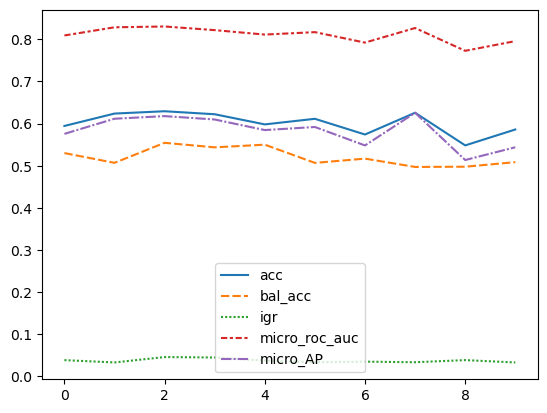

CA1-ProS_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [00:58<00:00,  2.95s/trial, best loss: -0.3644042362530074] 
CA1-ProS_Glut
IGR: 0.037; Balanced Accuracy: 0.459; Acuracy: 0.589; micro AP: 0.557; micro AUROC: 0.782


 99%|===================| 24169/24447 [00:30<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
1 : 141
100%|██████████| 20/20 [00:51<00:00,  2.59s/trial, best loss: -0.3765680673477768]
CA1-ProS_Glut
IGR: 0.040; Balanced Accuracy: 0.470; Acuracy: 0.667; micro AP: 0.695; micro AUROC: 0.837


 99%|===================| 24131/24447 [01:10<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
2 : 115
100%|██████████| 20/20 [00:49<00:00,  2.49s/trial, best loss: -0.3719974918841491] 
CA1-ProS_Glut
IGR: 0.040; Balanced Accuracy: 0.466; Acuracy: 0.576; micro AP: 0.524; micro AUROC: 0.765


 99%|===================| 24315/24447 [00:30<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
3 : 93
100%|██████████| 20/20 [00:40<00:00,  2.02s/trial, best loss: -0.3814229487768103]
CA1-ProS_Glut
IGR: 0.038; Balanced Accuracy: 0.463; Acuracy: 0.582; micro AP: 0.589; micro AUROC: 0.785


 99%|===================| 24207/24447 [00:37<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
4 : 80
100%|██████████| 20/20 [00:39<00:00,  1.96s/trial, best loss: -0.37102029569808503]
CA1-ProS_Glut
IGR: 0.035; Balanced Accuracy: 0.459; Acuracy: 0.600; micro AP: 0.568; micro AUROC: 0.782


 99%|===================| 24220/24447 [00:34<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
5 : 66
100%|██████████| 20/20 [00:38<00:00,  1.94s/trial, best loss: -0.3774293023717401] 
CA1-ProS_Glut
IGR: 0.040; Balanced Accuracy: 0.476; Acuracy: 0.605; micro AP: 0.608; micro AUROC: 0.797


100%|===================| 24326/24447 [00:38<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
6 : 55
100%|██████████| 20/20 [00:34<00:00,  1.74s/trial, best loss: -0.3642496901191763]
CA1-ProS_Glut
IGR: 0.040; Balanced Accuracy: 0.470; Acuracy: 0.647; micro AP: 0.667; micro AUROC: 0.827


 99%|===================| 24299/24447 [01:02<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
7 : 48
100%|██████████| 20/20 [00:29<00:00,  1.50s/trial, best loss: -0.37214540033143156]
CA1-ProS_Glut
IGR: 0.038; Balanced Accuracy: 0.466; Acuracy: 0.607; micro AP: 0.603; micro AUROC: 0.797


 99%|===================| 24270/24447 [00:51<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
8 : 44
100%|██████████| 20/20 [00:29<00:00,  1.47s/trial, best loss: -0.36825938541885] 
CA1-ProS_Glut
IGR: 0.037; Balanced Accuracy: 0.467; Acuracy: 0.579; micro AP: 0.533; micro AUROC: 0.762


 98%|===================| 24029/24447 [00:54<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
DEG
1    2615
0    1673
2     942
Name: count, dtype: int64
9 : 38
100%|██████████| 20/20 [00:28<00:00,  1.43s/trial, best loss: -0.37472041867463163]
CA1-ProS_Glut
IGR: 0.045; Balanced Accuracy: 0.483; Acuracy: 0.590; micro AP: 0.562; micro AUROC: 0.778


 99%|===================| 24318/24447 [00:49<00:00]        

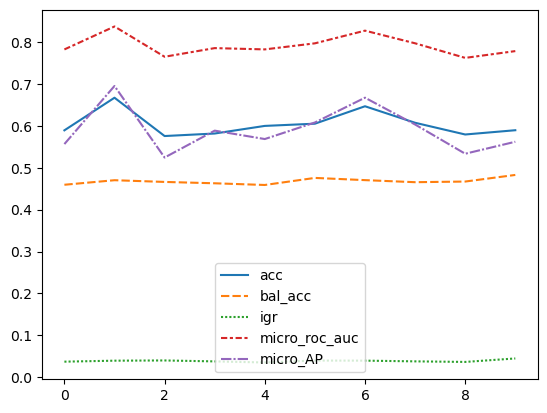

CA3_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
0 : 173
100%|██████████| 20/20 [00:56<00:00,  2.83s/trial, best loss: -0.22730870638155384]
CA3_Glut
IGR: 0.036; Balanced Accuracy: 0.530; Acuracy: 0.430; micro AP: 0.403; micro AUROC: 0.655


 99%|===================| 25750/26031 [00:29<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
1 : 159
100%|██████████| 20/20 [00:56<00:00,  2.83s/trial, best loss: -0.2241942711452322] 
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.517; Acuracy: 0.533; micro AP: 0.496; micro AUROC: 0.736


 99%|===================| 25732/26031 [01:06<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
2 : 125
100%|██████████| 20/20 [00:48<00:00,  2.43s/trial, best loss: -0.22718259330942442]
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.524; Acuracy: 0.445; micro AP: 0.419; micro AUROC: 0.670


100%|===================| 25943/26031 [00:40<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
3 : 105
100%|██████████| 20/20 [00:46<00:00,  2.31s/trial, best loss: -0.23851417130246153]
CA3_Glut
IGR: 0.041; Balanced Accuracy: 0.540; Acuracy: 0.479; micro AP: 0.431; micro AUROC: 0.678


 98%|===================| 25440/26031 [00:43<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
4 : 87
100%|██████████| 20/20 [00:42<00:00,  2.15s/trial, best loss: -0.2250624237373199]
CA3_Glut
IGR: 0.041; Balanced Accuracy: 0.541; Acuracy: 0.501; micro AP: 0.470; micro AUROC: 0.713


100%|===================| 25951/26031 [01:23<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
5 : 70
100%|██████████| 20/20 [00:38<00:00,  1.93s/trial, best loss: -0.22566204292365705]
CA3_Glut
IGR: 0.038; Balanced Accuracy: 0.542; Acuracy: 0.454; micro AP: 0.424; micro AUROC: 0.679


 98%|===================| 25531/26031 [00:43<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
6 : 58
100%|██████████| 20/20 [00:34<00:00,  1.74s/trial, best loss: -0.22612007900650904]
CA3_Glut
IGR: 0.036; Balanced Accuracy: 0.536; Acuracy: 0.462; micro AP: 0.436; micro AUROC: 0.685


 99%|===================| 25767/26031 [01:28<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
7 : 49
100%|██████████| 20/20 [00:32<00:00,  1.61s/trial, best loss: -0.2289612188840732]
CA3_Glut
IGR: 0.039; Balanced Accuracy: 0.547; Acuracy: 0.464; micro AP: 0.431; micro AUROC: 0.675


100%|===================| 26020/26031 [01:24<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
8 : 43
100%|██████████| 20/20 [00:29<00:00,  1.48s/trial, best loss: -0.23354096309029687]
CA3_Glut
IGR: 0.037; Balanced Accuracy: 0.538; Acuracy: 0.455; micro AP: 0.430; micro AUROC: 0.678


 99%|===================| 25717/26031 [01:01<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
DEG
1    2973
0    1986
2     987
Name: count, dtype: int64
9 : 40
100%|██████████| 20/20 [00:32<00:00,  1.60s/trial, best loss: -0.22572427846506615]
CA3_Glut
IGR: 0.038; Balanced Accuracy: 0.547; Acuracy: 0.453; micro AP: 0.425; micro AUROC: 0.673


 99%|===================| 25743/26031 [01:03<00:00]        

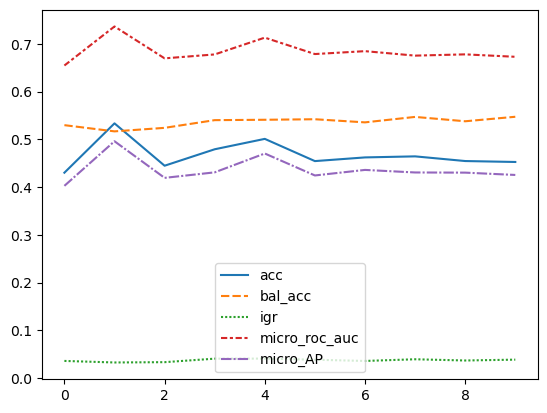

CTX_Hipo_Glut
L23_IT_CTX_Glut
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
0 : 205
100%|██████████| 20/20 [01:19<00:00,  4.00s/trial, best loss: -0.3839548556277967]
L23_IT_CTX_Glut
IGR: 0.060; Balanced Accuracy: 0.518; Acuracy: 0.510; micro AP: 0.503; micro AUROC: 0.744


100%|===================| 28043/28059 [01:26<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
1 : 164
100%|██████████| 20/20 [01:10<00:00,  3.54s/trial, best loss: -0.37828497901547864]
L23_IT_CTX_Glut
IGR: 0.058; Balanced Accuracy: 0.502; Acuracy: 0.519; micro AP: 0.506; micro AUROC: 0.746


 99%|===================| 27786/28059 [01:16<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
2 : 136
100%|██████████| 20/20 [00:50<00:00,  2.53s/trial, best loss: -0.38359636792848983]
L23_IT_CTX_Glut
IGR: 0.057; Balanced Accuracy: 0.510; Acuracy: 0.516; micro AP: 0.501; micro AUROC: 0.744


 99%|===================| 27833/28059 [01:08<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
3 : 114
100%|██████████| 20/20 [00:47<00:00,  2.37s/trial, best loss: -0.3824668302670369]
L23_IT_CTX_Glut
IGR: 0.059; Balanced Accuracy: 0.525; Acuracy: 0.496; micro AP: 0.478; micro AUROC: 0.726


 99%|===================| 27737/28059 [01:16<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
4 : 98
100%|██████████| 20/20 [00:46<00:00,  2.31s/trial, best loss: -0.3835890962950368] 
L23_IT_CTX_Glut
IGR: 0.057; Balanced Accuracy: 0.510; Acuracy: 0.518; micro AP: 0.504; micro AUROC: 0.746


 99%|===================| 27681/28059 [01:13<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
5 : 81
100%|██████████| 20/20 [00:44<00:00,  2.23s/trial, best loss: -0.3805436794761843]
L23_IT_CTX_Glut
IGR: 0.060; Balanced Accuracy: 0.516; Acuracy: 0.504; micro AP: 0.489; micro AUROC: 0.732


100%|===================| 28016/28059 [02:33<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
6 : 65
100%|██████████| 20/20 [00:28<00:00,  1.43s/trial, best loss: -0.381633503619416] 
L23_IT_CTX_Glut
IGR: 0.052; Balanced Accuracy: 0.502; Acuracy: 0.486; micro AP: 0.473; micro AUROC: 0.723


 99%|===================| 27645/28059 [01:05<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
7 : 57
100%|██████████| 20/20 [00:26<00:00,  1.31s/trial, best loss: -0.38263880705807674]
L23_IT_CTX_Glut
IGR: 0.057; Balanced Accuracy: 0.516; Acuracy: 0.494; micro AP: 0.476; micro AUROC: 0.724


100%|===================| 27952/28059 [01:20<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
8 : 50
100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.37902766744920247]
L23_IT_CTX_Glut
IGR: 0.062; Balanced Accuracy: 0.519; Acuracy: 0.532; micro AP: 0.512; micro AUROC: 0.751


 99%|===================| 27872/28059 [01:55<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4232
0    2522
2    1710
Name: count, dtype: int64
9 : 45
100%|██████████| 20/20 [00:22<00:00,  1.10s/trial, best loss: -0.3829027686842066]
L23_IT_CTX_Glut
IGR: 0.059; Balanced Accuracy: 0.520; Acuracy: 0.506; micro AP: 0.486; micro AUROC: 0.729


100%|===================| 27962/28059 [01:41<00:00]        

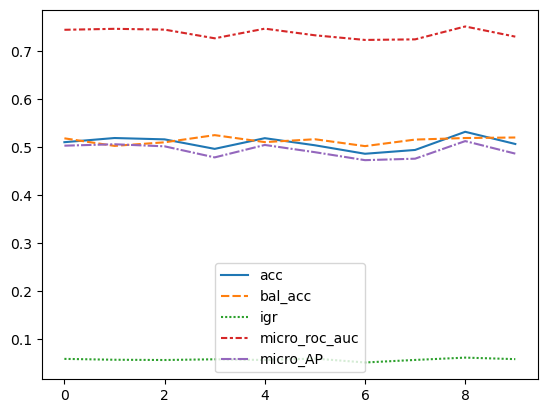

L6_IT_CTX_Glut
zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
0 : 205
100%|██████████| 20/20 [01:13<00:00,  3.67s/trial, best loss: 0.8370472272543455]
L6_IT_CTX_Glut
IGR: 0.063; Balanced Accuracy: 0.585; Acuracy: 0.629; micro AP: 0.651; micro AUROC: 0.834


100%|===================| 27749/27759 [01:55<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
1 : 158
100%|██████████| 20/20 [00:52<00:00,  2.64s/trial, best loss: 0.8321461139476136]
L6_IT_CTX_Glut
IGR: 0.059; Balanced Accuracy: 0.587; Acuracy: 0.621; micro AP: 0.615; micro AUROC: 0.825


 99%|===================| 27564/27759 [02:13<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
2 : 126
100%|██████████| 20/20 [00:58<00:00,  2.92s/trial, best loss: 0.8318503252028538]
L6_IT_CTX_Glut
IGR: 0.069; Balanced Accuracy: 0.597; Acuracy: 0.664; micro AP: 0.663; micro AUROC: 0.849


100%|===================| 27723/27759 [02:39<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
3 : 98
100%|██████████| 20/20 [00:43<00:00,  2.18s/trial, best loss: 0.829673460037105]
L6_IT_CTX_Glut
IGR: 0.079; Balanced Accuracy: 0.640; Acuracy: 0.620; micro AP: 0.616; micro AUROC: 0.824


 98%|===================| 27154/27759 [00:44<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
4 : 82
100%|██████████| 20/20 [00:49<00:00,  2.45s/trial, best loss: 0.8217891722616109]
L6_IT_CTX_Glut
IGR: 0.062; Balanced Accuracy: 0.586; Acuracy: 0.576; micro AP: 0.548; micro AUROC: 0.790


 99%|===================| 27556/27759 [01:41<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
5 : 71
100%|██████████| 20/20 [00:44<00:00,  2.22s/trial, best loss: 0.8263555784146421]
L6_IT_CTX_Glut
IGR: 0.080; Balanced Accuracy: 0.632; Acuracy: 0.621; micro AP: 0.615; micro AUROC: 0.822


 99%|===================| 27609/27759 [02:06<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
6 : 64
100%|██████████| 20/20 [00:42<00:00,  2.11s/trial, best loss: 0.837552067899144]
L6_IT_CTX_Glut
IGR: 0.077; Balanced Accuracy: 0.632; Acuracy: 0.613; micro AP: 0.585; micro AUROC: 0.812


 99%|===================| 27479/27759 [01:38<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
7 : 56
100%|██████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: 0.83635112114047]  
L6_IT_CTX_Glut
IGR: 0.072; Balanced Accuracy: 0.626; Acuracy: 0.625; micro AP: 0.635; micro AUROC: 0.830


 99%|===================| 27558/27759 [01:45<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
8 : 50
100%|██████████| 20/20 [00:34<00:00,  1.72s/trial, best loss: 0.8365556319473402]
L6_IT_CTX_Glut
IGR: 0.065; Balanced Accuracy: 0.608; Acuracy: 0.597; micro AP: 0.572; micro AUROC: 0.800


 99%|===================| 27589/27759 [02:15<00:00]        

zero: 7789, non-zero: 1564
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    5606
0    3725
2    1881
Name: count, dtype: int64
9 : 46
100%|██████████| 20/20 [00:33<00:00,  1.66s/trial, best loss: 0.8193826799345864]
L6_IT_CTX_Glut
IGR: 0.082; Balanced Accuracy: 0.616; Acuracy: 0.659; micro AP: 0.677; micro AUROC: 0.851


100%|===================| 27724/27759 [02:13<00:00]        

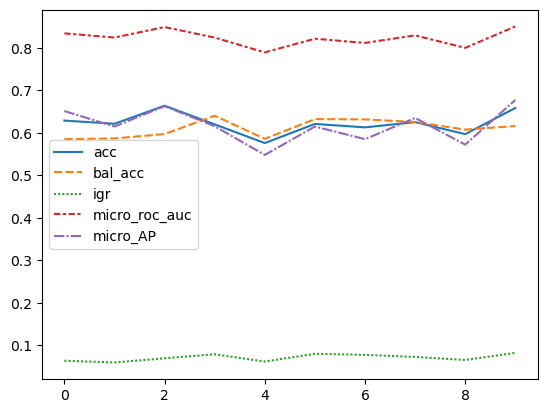

CA1-ProS_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [01:08<00:00,  3.45s/trial, best loss: -0.4030635958192872]
CA1-ProS_Glut
IGR: 0.039; Balanced Accuracy: 0.472; Acuracy: 0.568; micro AP: 0.572; micro AUROC: 0.771


 99%|===================| 24262/24447 [01:16<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
1 : 145
100%|██████████| 20/20 [00:56<00:00,  2.83s/trial, best loss: -0.3990592383668517]
CA1-ProS_Glut
IGR: 0.036; Balanced Accuracy: 0.466; Acuracy: 0.549; micro AP: 0.514; micro AUROC: 0.745


 99%|===================| 24279/24447 [01:09<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
2 : 116
100%|██████████| 20/20 [00:52<00:00,  2.65s/trial, best loss: -0.4018475606199051]
CA1-ProS_Glut
IGR: 0.033; Balanced Accuracy: 0.463; Acuracy: 0.545; micro AP: 0.529; micro AUROC: 0.751


 99%|===================| 24306/24447 [01:15<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
3 : 102
100%|██████████| 20/20 [00:48<00:00,  2.41s/trial, best loss: -0.40762742801160645]
CA1-ProS_Glut
IGR: 0.036; Balanced Accuracy: 0.466; Acuracy: 0.586; micro AP: 0.578; micro AUROC: 0.777


100%|===================| 24412/24447 [01:06<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
4 : 81
100%|██████████| 20/20 [00:41<00:00,  2.09s/trial, best loss: -0.4012217038220339]
CA1-ProS_Glut
IGR: 0.041; Balanced Accuracy: 0.473; Acuracy: 0.564; micro AP: 0.547; micro AUROC: 0.763


 99%|===================| 24251/24447 [00:59<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
5 : 71
100%|██████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: -0.4003352656505947]
CA1-ProS_Glut
IGR: 0.038; Balanced Accuracy: 0.469; Acuracy: 0.552; micro AP: 0.513; micro AUROC: 0.744


 98%|===================| 24061/24447 [00:39<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
6 : 64
100%|██████████| 20/20 [00:38<00:00,  1.94s/trial, best loss: -0.40086628465858143]
CA1-ProS_Glut
IGR: 0.039; Balanced Accuracy: 0.471; Acuracy: 0.528; micro AP: 0.513; micro AUROC: 0.737


100%|===================| 24381/24447 [00:42<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
7 : 55
100%|██████████| 20/20 [00:28<00:00,  1.41s/trial, best loss: -0.40616924490039485]
CA1-ProS_Glut
IGR: 0.034; Balanced Accuracy: 0.460; Acuracy: 0.525; micro AP: 0.497; micro AUROC: 0.731


 98%|===================| 23965/24447 [00:49<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
8 : 48
100%|██████████| 20/20 [00:25<00:00,  1.26s/trial, best loss: -0.4052341121561792] 
CA1-ProS_Glut
IGR: 0.041; Balanced Accuracy: 0.479; Acuracy: 0.556; micro AP: 0.550; micro AUROC: 0.761


 99%|===================| 24278/24447 [01:10<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4577
0    3416
2    1161
Name: count, dtype: int64
9 : 45
100%|██████████| 20/20 [00:24<00:00,  1.22s/trial, best loss: -0.4002254589303087] 
CA1-ProS_Glut
IGR: 0.038; Balanced Accuracy: 0.470; Acuracy: 0.586; micro AP: 0.564; micro AUROC: 0.771


 99%|===================| 24306/24447 [01:25<00:00]        

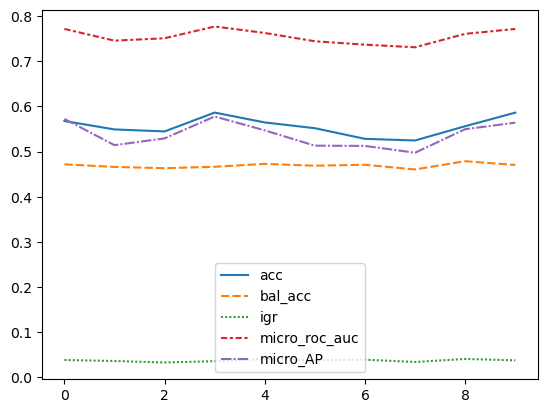

CA3_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
0 : 179
100%|██████████| 20/20 [01:05<00:00,  3.26s/trial, best loss: -0.25675947997872023]
CA3_Glut
IGR: 0.030; Balanced Accuracy: 0.505; Acuracy: 0.464; micro AP: 0.432; micro AUROC: 0.680


 99%|===================| 25789/26031 [01:03<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
1 : 139
100%|██████████| 20/20 [00:53<00:00,  2.67s/trial, best loss: -0.266961553044503]  
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.524; Acuracy: 0.521; micro AP: 0.487; micro AUROC: 0.722


 99%|===================| 25804/26031 [01:47<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
2 : 109
100%|██████████| 20/20 [00:46<00:00,  2.35s/trial, best loss: -0.2562257208139558]
CA3_Glut
IGR: 0.031; Balanced Accuracy: 0.514; Acuracy: 0.491; micro AP: 0.458; micro AUROC: 0.697


100%|===================| 25941/26031 [02:13<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
3 : 91
100%|██████████| 20/20 [00:43<00:00,  2.17s/trial, best loss: -0.2570111601252532]
CA3_Glut
IGR: 0.034; Balanced Accuracy: 0.526; Acuracy: 0.524; micro AP: 0.488; micro AUROC: 0.718


 99%|===================| 25885/26031 [02:16<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
4 : 73
100%|██████████| 20/20 [00:33<00:00,  1.69s/trial, best loss: -0.2630576722984818]
CA3_Glut
IGR: 0.034; Balanced Accuracy: 0.523; Acuracy: 0.425; micro AP: 0.409; micro AUROC: 0.657


 99%|===================| 25870/26031 [00:52<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
5 : 60
100%|██████████| 20/20 [00:31<00:00,  1.56s/trial, best loss: -0.2559265399588747] 
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.524; Acuracy: 0.446; micro AP: 0.413; micro AUROC: 0.653


100%|===================| 25991/26031 [01:35<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
6 : 53
100%|██████████| 20/20 [00:35<00:00,  1.77s/trial, best loss: -0.25311091906955907]
CA3_Glut
IGR: 0.034; Balanced Accuracy: 0.524; Acuracy: 0.464; micro AP: 0.430; micro AUROC: 0.676


 99%|===================| 25805/26031 [01:06<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
7 : 45
100%|██████████| 20/20 [00:27<00:00,  1.40s/trial, best loss: -0.2639226442280699]
CA3_Glut
IGR: 0.034; Balanced Accuracy: 0.523; Acuracy: 0.455; micro AP: 0.418; micro AUROC: 0.664


 99%|===================| 25887/26031 [01:10<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
8 : 44
100%|██████████| 20/20 [00:24<00:00,  1.20s/trial, best loss: -0.2679397664519241]
CA3_Glut
IGR: 0.032; Balanced Accuracy: 0.515; Acuracy: 0.429; micro AP: 0.396; micro AUROC: 0.639


 99%|===================| 25763/26031 [01:26<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
DEG
1    4935
0    3729
2    1206
Name: count, dtype: int64
9 : 38
100%|██████████| 20/20 [00:30<00:00,  1.53s/trial, best loss: -0.2623786024076303]
CA3_Glut
IGR: 0.033; Balanced Accuracy: 0.514; Acuracy: 0.439; micro AP: 0.409; micro AUROC: 0.658


 99%|===================| 25759/26031 [01:09<00:00]        

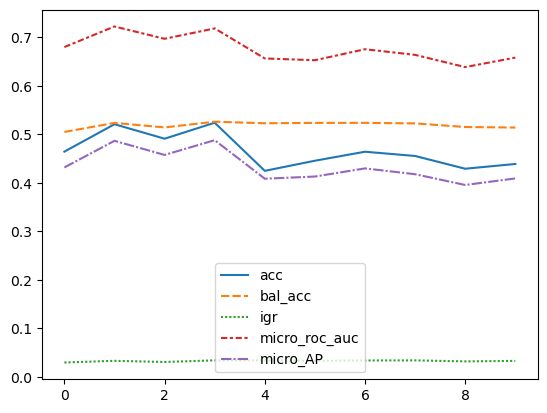

L6_CT_CTX_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
0 : 221
100%|██████████| 20/20 [01:13<00:00,  3.66s/trial, best loss: -0.33578425957176633]
L6_CT_CTX_Glut
IGR: 0.075; Balanced Accuracy: 0.566; Acuracy: 0.539; micro AP: 0.531; micro AUROC: 0.767


100%|===================| 27951/28068 [01:04<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
1 : 176
100%|██████████| 20/20 [01:01<00:00,  3.07s/trial, best loss: -0.33758736431155023]
L6_CT_CTX_Glut
IGR: 0.079; Balanced Accuracy: 0.564; Acuracy: 0.550; micro AP: 0.534; micro AUROC: 0.770


 99%|===================| 27766/28068 [01:30<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
2 : 139
100%|██████████| 20/20 [00:59<00:00,  2.99s/trial, best loss: -0.3347457233993693]
L6_CT_CTX_Glut
IGR: 0.079; Balanced Accuracy: 0.564; Acuracy: 0.540; micro AP: 0.533; micro AUROC: 0.767


 99%|===================| 27901/28068 [01:48<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
3 : 120
100%|██████████| 20/20 [00:59<00:00,  2.98s/trial, best loss: -0.33610354529991404]
L6_CT_CTX_Glut
IGR: 0.077; Balanced Accuracy: 0.565; Acuracy: 0.560; micro AP: 0.551; micro AUROC: 0.779


 99%|===================| 27871/28068 [01:36<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
4 : 100
100%|██████████| 20/20 [00:47<00:00,  2.37s/trial, best loss: -0.33678141297092185]
L6_CT_CTX_Glut
IGR: 0.071; Balanced Accuracy: 0.552; Acuracy: 0.541; micro AP: 0.529; micro AUROC: 0.766


 99%|===================| 27925/28068 [01:03<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
5 : 81
100%|██████████| 20/20 [00:43<00:00,  2.16s/trial, best loss: -0.3378519886434777]
L6_CT_CTX_Glut
IGR: 0.081; Balanced Accuracy: 0.571; Acuracy: 0.549; micro AP: 0.532; micro AUROC: 0.768


 99%|===================| 27925/28068 [01:40<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
6 : 70
100%|██████████| 20/20 [00:38<00:00,  1.94s/trial, best loss: -0.3398753394274105]
L6_CT_CTX_Glut
IGR: 0.081; Balanced Accuracy: 0.564; Acuracy: 0.560; micro AP: 0.550; micro AUROC: 0.778


 99%|===================| 27906/28068 [01:37<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
7 : 62
100%|██████████| 20/20 [00:39<00:00,  1.96s/trial, best loss: -0.3499482554011014] 
L6_CT_CTX_Glut
IGR: 0.089; Balanced Accuracy: 0.576; Acuracy: 0.590; micro AP: 0.578; micro AUROC: 0.795


 99%|===================| 27878/28068 [01:33<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
8 : 56
100%|██████████| 20/20 [00:38<00:00,  1.91s/trial, best loss: -0.3428760431370777]
L6_CT_CTX_Glut
IGR: 0.082; Balanced Accuracy: 0.560; Acuracy: 0.597; micro AP: 0.601; micro AUROC: 0.807


100%|===================| 27983/28068 [03:15<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 8692, non-zero: 491
DEG
1    4325
0    2553
2    1772
Name: count, dtype: int64
9 : 52
100%|██████████| 20/20 [00:26<00:00,  1.35s/trial, best loss: -0.34522318311406597]
L6_CT_CTX_Glut
IGR: 0.078; Balanced Accuracy: 0.570; Acuracy: 0.544; micro AP: 0.534; micro AUROC: 0.768


100%|===================| 27945/28068 [01:03<00:00]        

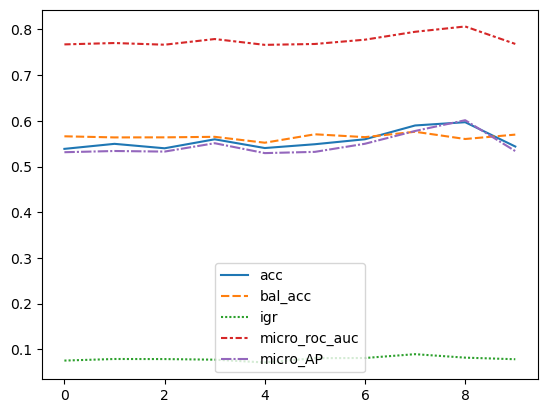

L5_ET_CTX_Glut
zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
0 : 195
100%|██████████| 20/20 [01:15<00:00,  3.76s/trial, best loss: 0.01773640235174524]
L5_ET_CTX_Glut
IGR: 0.070; Balanced Accuracy: 0.573; Acuracy: 0.659; micro AP: 0.667; micro AUROC: 0.842


 99%|===================| 27389/27549 [01:35<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
1 : 153
100%|██████████| 20/20 [00:54<00:00,  2.73s/trial, best loss: 0.017797484687837196]
L5_ET_CTX_Glut
IGR: 0.063; Balanced Accuracy: 0.568; Acuracy: 0.617; micro AP: 0.602; micro AUROC: 0.813


 99%|===================| 27217/27549 [01:18<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
2 : 128
100%|██████████| 20/20 [00:48<00:00,  2.44s/trial, best loss: 0.01911713563254904] 
L5_ET_CTX_Glut
IGR: 0.062; Balanced Accuracy: 0.557; Acuracy: 0.617; micro AP: 0.589; micro AUROC: 0.808


 99%|===================| 27378/27549 [01:07<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
3 : 106
100%|██████████| 20/20 [00:42<00:00,  2.12s/trial, best loss: 0.019619444611426874]
L5_ET_CTX_Glut
IGR: 0.065; Balanced Accuracy: 0.567; Acuracy: 0.669; micro AP: 0.689; micro AUROC: 0.851


 99%|===================| 27323/27549 [01:20<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
4 : 92
100%|██████████| 20/20 [00:39<00:00,  1.97s/trial, best loss: 0.016022247947102098]
L5_ET_CTX_Glut
IGR: 0.059; Balanced Accuracy: 0.562; Acuracy: 0.636; micro AP: 0.643; micro AUROC: 0.826


 99%|===================| 27377/27549 [01:41<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
5 : 80
100%|██████████| 20/20 [00:44<00:00,  2.25s/trial, best loss: 0.016656577653828008]
L5_ET_CTX_Glut
IGR: 0.054; Balanced Accuracy: 0.549; Acuracy: 0.658; micro AP: 0.660; micro AUROC: 0.839


 99%|===================| 27406/27549 [02:24<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
6 : 67
100%|██████████| 20/20 [00:40<00:00,  2.04s/trial, best loss: 0.01064926004729303] 
L5_ET_CTX_Glut
IGR: 0.066; Balanced Accuracy: 0.571; Acuracy: 0.635; micro AP: 0.625; micro AUROC: 0.822


 99%|===================| 27364/27549 [01:47<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
7 : 59
100%|██████████| 20/20 [00:32<00:00,  1.63s/trial, best loss: 0.024935928274761508]
L5_ET_CTX_Glut
IGR: 0.066; Balanced Accuracy: 0.569; Acuracy: 0.657; micro AP: 0.663; micro AUROC: 0.841


 99%|===================| 27274/27549 [01:38<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
8 : 53
100%|██████████| 20/20 [00:26<00:00,  1.33s/trial, best loss: 0.025809518119860098]
L5_ET_CTX_Glut
IGR: 0.055; Balanced Accuracy: 0.543; Acuracy: 0.641; micro AP: 0.651; micro AUROC: 0.834


 99%|===================| 27324/27549 [00:56<00:00]        

zero: 7789, non-zero: 1564
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
DEG
1    5305
0    3470
2    1835
Name: count, dtype: int64
9 : 49
100%|██████████| 20/20 [00:29<00:00,  1.50s/trial, best loss: 0.01714259237615807]
L5_ET_CTX_Glut
IGR: 0.063; Balanced Accuracy: 0.535; Acuracy: 0.672; micro AP: 0.691; micro AUROC: 0.851


100%|===================| 27466/27549 [02:23<00:00]        

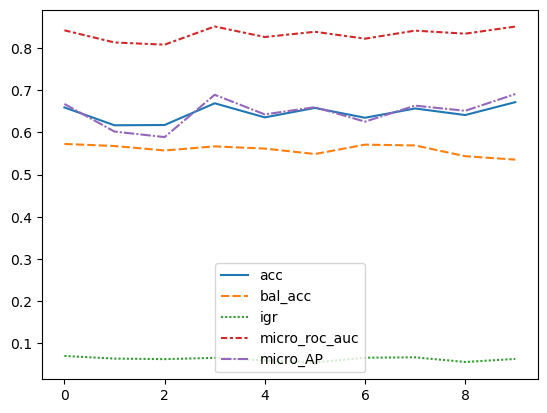

NN_DG_Glut
Astro-TE_NN
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
0 : 235
100%|██████████| 20/20 [01:31<00:00,  4.55s/trial, best loss: 0.34841137550363765]
Astro-TE_NN
IGR: 0.093; Balanced Accuracy: 0.626; Acuracy: 0.588; micro AP: 0.499; micro AUROC: 0.760


 99%|===================| 19688/19887 [00:41<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
1 : 179
100%|██████████| 20/20 [01:12<00:00,  3.64s/trial, best loss: 0.3485139422986485]
Astro-TE_NN
IGR: 0.107; Balanced Accuracy: 0.653; Acuracy: 0.595; micro AP: 0.515; micro AUROC: 0.770


100%|===================| 19836/19887 [00:56<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
2 : 144
100%|██████████| 20/20 [01:05<00:00,  3.29s/trial, best loss: 0.34465840795284264]
Astro-TE_NN
IGR: 0.090; Balanced Accuracy: 0.627; Acuracy: 0.545; micro AP: 0.474; micro AUROC: 0.739


 98%|===================| 19483/19887 [00:38<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
3 : 117
100%|██████████| 20/20 [00:53<00:00,  2.69s/trial, best loss: 0.35066799784011904]
Astro-TE_NN
IGR: 0.109; Balanced Accuracy: 0.662; Acuracy: 0.572; micro AP: 0.490; micro AUROC: 0.751


 99%|===================| 19650/19887 [00:44<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
4 : 98
100%|██████████| 20/20 [00:47<00:00,  2.37s/trial, best loss: 0.3424313871906467]
Astro-TE_NN
IGR: 0.100; Balanced Accuracy: 0.641; Acuracy: 0.591; micro AP: 0.521; micro AUROC: 0.775


 99%|===================| 19769/19887 [01:07<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
5 : 75
100%|██████████| 20/20 [00:35<00:00,  1.80s/trial, best loss: 0.34258487141525895]
Astro-TE_NN
IGR: 0.110; Balanced Accuracy: 0.654; Acuracy: 0.574; micro AP: 0.501; micro AUROC: 0.760


 99%|===================| 19617/19887 [00:49<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
6 : 65
100%|██████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: 0.35396460447981787]
Astro-TE_NN
IGR: 0.107; Balanced Accuracy: 0.658; Acuracy: 0.518; micro AP: 0.454; micro AUROC: 0.726


100%|===================| 19838/19887 [00:31<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
7 : 53
100%|██████████| 20/20 [00:31<00:00,  1.56s/trial, best loss: 0.33309903939300467]
Astro-TE_NN
IGR: 0.106; Balanced Accuracy: 0.650; Acuracy: 0.564; micro AP: 0.490; micro AUROC: 0.751


 99%|===================| 19765/19887 [01:16<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
8 : 43
100%|██████████| 20/20 [00:26<00:00,  1.34s/trial, best loss: 0.332309308693969] 
Astro-TE_NN
IGR: 0.097; Balanced Accuracy: 0.633; Acuracy: 0.553; micro AP: 0.471; micro AUROC: 0.737


 98%|===================| 19558/19887 [00:59<00:00]        

zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    4556
0    3670
2     886
Name: count, dtype: int64
9 : 35
100%|██████████| 20/20 [00:23<00:00,  1.20s/trial, best loss: 0.34268309823417215]
Astro-TE_NN
IGR: 0.095; Balanced Accuracy: 0.630; Acuracy: 0.581; micro AP: 0.504; micro AUROC: 0.764


 98%|===================| 19551/19887 [00:44<00:00]        

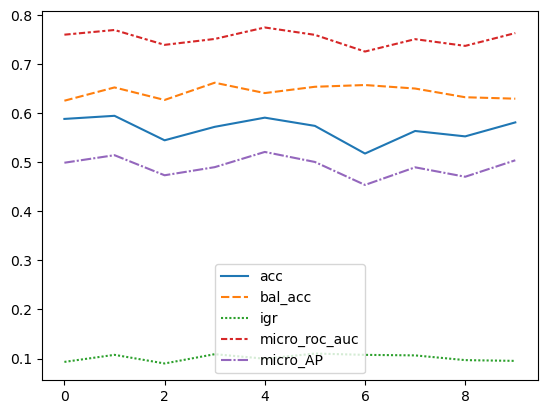

Oligo_NN
zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
0 : 219
100%|██████████| 20/20 [01:07<00:00,  3.38s/trial, best loss: -0.4924793828875704]
Oligo_NN
IGR: 0.108; Balanced Accuracy: 0.566; Acuracy: 0.626; micro AP: 0.631; micro AUROC: 0.801


 99%|===================| 16423/16638 [00:22<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
1 : 159
100%|██████████| 20/20 [01:01<00:00,  3.09s/trial, best loss: -0.48386695056872436]
Oligo_NN
IGR: 0.101; Balanced Accuracy: 0.557; Acuracy: 0.615; micro AP: 0.626; micro AUROC: 0.798


 98%|===================| 16323/16638 [00:32<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
2 : 128
100%|██████████| 20/20 [00:41<00:00,  2.05s/trial, best loss: -0.4839897896613696]
Oligo_NN
IGR: 0.100; Balanced Accuracy: 0.555; Acuracy: 0.622; micro AP: 0.638; micro AUROC: 0.803


 98%|===================| 16324/16638 [00:24<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
3 : 104
100%|██████████| 20/20 [00:36<00:00,  1.85s/trial, best loss: -0.49192524082274075]
Oligo_NN
IGR: 0.103; Balanced Accuracy: 0.566; Acuracy: 0.611; micro AP: 0.614; micro AUROC: 0.792


 99%|===================| 16534/16638 [00:27<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
4 : 85
100%|██████████| 20/20 [00:31<00:00,  1.59s/trial, best loss: -0.4890015554556462] 
Oligo_NN
IGR: 0.105; Balanced Accuracy: 0.567; Acuracy: 0.600; micro AP: 0.604; micro AUROC: 0.782


 96%|=================== | 15989/16638 [00:26<00:01]       

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
5 : 66
100%|██████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: -0.48793298923360495]
Oligo_NN
IGR: 0.102; Balanced Accuracy: 0.555; Acuracy: 0.619; micro AP: 0.638; micro AUROC: 0.800


 99%|===================| 16523/16638 [00:55<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
6 : 53
100%|██████████| 20/20 [00:24<00:00,  1.21s/trial, best loss: -0.4831496664328764]
Oligo_NN
IGR: 0.114; Balanced Accuracy: 0.574; Acuracy: 0.621; micro AP: 0.625; micro AUROC: 0.799


 98%|===================| 16315/16638 [00:26<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
7 : 43
100%|██████████| 20/20 [00:40<00:00,  2.02s/trial, best loss: -0.4887112720822162] 
Oligo_NN
IGR: 0.113; Balanced Accuracy: 0.577; Acuracy: 0.615; micro AP: 0.619; micro AUROC: 0.792


 99%|===================| 16394/16638 [00:27<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
8 : 36
100%|██████████| 20/20 [00:38<00:00,  1.93s/trial, best loss: -0.48798079388422533]
Oligo_NN
IGR: 0.123; Balanced Accuracy: 0.586; Acuracy: 0.622; micro AP: 0.615; micro AUROC: 0.795


100%|===================| 16611/16638 [00:21<00:00]        

zero: 6436, non-zero: 193
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
DEG
1    3212
0    2839
2     373
Name: count, dtype: int64
9 : 30
100%|██████████| 20/20 [00:26<00:00,  1.33s/trial, best loss: -0.4840115797324648]
Oligo_NN
IGR: 0.111; Balanced Accuracy: 0.577; Acuracy: 0.595; micro AP: 0.602; micro AUROC: 0.783


 98%|===================| 16285/16638 [00:35<00:00]        

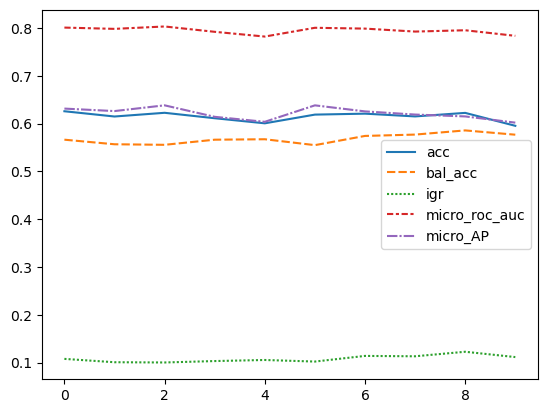

OPC_NN
zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
0 : 189
100%|██████████| 20/20 [01:09<00:00,  3.47s/trial, best loss: 0.4374601264874641]
OPC_NN
IGR: 0.104; Balanced Accuracy: 0.586; Acuracy: 0.529; micro AP: 0.458; micro AUROC: 0.728


 98%|===================| 18979/19296 [00:41<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
1 : 147
100%|██████████| 20/20 [00:55<00:00,  2.78s/trial, best loss: 0.4380321043266854]
OPC_NN
IGR: 0.123; Balanced Accuracy: 0.620; Acuracy: 0.540; micro AP: 0.470; micro AUROC: 0.737


100%|===================| 19200/19296 [00:53<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
2 : 114
100%|██████████| 20/20 [00:45<00:00,  2.28s/trial, best loss: 0.43886366690362094]
OPC_NN
IGR: 0.090; Balanced Accuracy: 0.561; Acuracy: 0.527; micro AP: 0.452; micro AUROC: 0.718


 98%|===================| 19006/19296 [00:33<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
3 : 94
100%|██████████| 20/20 [00:42<00:00,  2.10s/trial, best loss: 0.4482738666962046]
OPC_NN
IGR: 0.113; Balanced Accuracy: 0.595; Acuracy: 0.443; micro AP: 0.395; micro AUROC: 0.664


 99%|===================| 19147/19296 [00:42<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
4 : 75
100%|██████████| 20/20 [00:39<00:00,  1.96s/trial, best loss: 0.43202801050160844]
OPC_NN
IGR: 0.114; Balanced Accuracy: 0.602; Acuracy: 0.519; micro AP: 0.467; micro AUROC: 0.729


 99%|===================| 19113/19296 [01:29<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
5 : 60
100%|██████████| 20/20 [00:31<00:00,  1.59s/trial, best loss: 0.44842319149034343]
OPC_NN
IGR: 0.109; Balanced Accuracy: 0.606; Acuracy: 0.535; micro AP: 0.478; micro AUROC: 0.739


 99%|===================| 19028/19296 [00:49<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
6 : 46
100%|██████████| 20/20 [00:24<00:00,  1.24s/trial, best loss: 0.4451019621394594]
OPC_NN
IGR: 0.114; Balanced Accuracy: 0.603; Acuracy: 0.605; micro AP: 0.540; micro AUROC: 0.787


 99%|===================| 19072/19296 [00:56<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
7 : 36
100%|██████████| 20/20 [00:22<00:00,  1.14s/trial, best loss: 0.4535565409461322]
OPC_NN
IGR: 0.120; Balanced Accuracy: 0.615; Acuracy: 0.568; micro AP: 0.522; micro AUROC: 0.770


 99%|===================| 19045/19296 [01:09<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
8 : 29
100%|██████████| 20/20 [00:27<00:00,  1.35s/trial, best loss: 0.45501552536060846]
OPC_NN
IGR: 0.108; Balanced Accuracy: 0.592; Acuracy: 0.513; micro AP: 0.449; micro AUROC: 0.716


 99%|===================| 19090/19296 [00:45<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 5461, non-zero: 2849
DEG
1    4579
0    3724
2     855
Name: count, dtype: int64
9 : 23
100%|██████████| 20/20 [00:19<00:00,  1.00trial/s, best loss: 0.46240964019132164]
OPC_NN
IGR: 0.118; Balanced Accuracy: 0.598; Acuracy: 0.504; micro AP: 0.450; micro AUROC: 0.712


 99%|===================| 19070/19296 [01:04<00:00]        

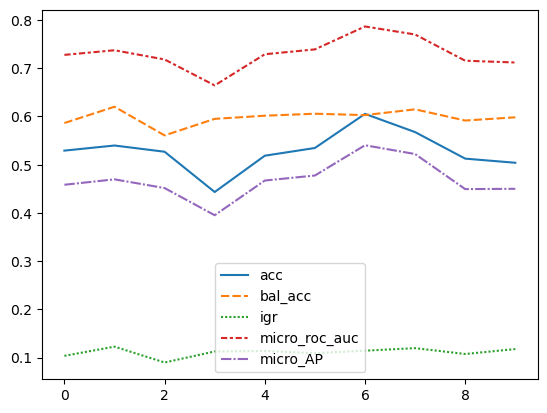

DG_Glut
zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
0 : 213
100%|██████████| 20/20 [00:48<00:00,  2.44s/trial, best loss: -0.5124983631602597]
DG_Glut
IGR: 0.019; Balanced Accuracy: 0.492; Acuracy: 0.422; micro AP: 0.415; micro AUROC: 0.654


100%|===================| 24833/24930 [00:48<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
1 : 162
100%|██████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: -0.514553988526567] 
DG_Glut
IGR: 0.020; Balanced Accuracy: 0.498; Acuracy: 0.416; micro AP: 0.404; micro AUROC: 0.642


 99%|===================| 24672/24930 [00:35<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
2 : 123
100%|██████████| 20/20 [00:44<00:00,  2.24s/trial, best loss: -0.5144989153717129]
DG_Glut
IGR: 0.021; Balanced Accuracy: 0.502; Acuracy: 0.439; micro AP: 0.426; micro AUROC: 0.662


 99%|===================| 24753/24930 [00:46<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
3 : 99
100%|██████████| 20/20 [00:27<00:00,  1.39s/trial, best loss: -0.5098109754772484]
DG_Glut
IGR: 0.021; Balanced Accuracy: 0.495; Acuracy: 0.436; micro AP: 0.421; micro AUROC: 0.656


 99%|===================| 24801/24930 [00:29<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
4 : 78
100%|██████████| 20/20 [00:24<00:00,  1.23s/trial, best loss: -0.5156152615600204]
DG_Glut
IGR: 0.023; Balanced Accuracy: 0.500; Acuracy: 0.449; micro AP: 0.433; micro AUROC: 0.670


 99%|===================| 24604/24930 [00:40<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
5 : 59
100%|██████████| 20/20 [00:20<00:00,  1.01s/trial, best loss: -0.5176377201631185]
DG_Glut
IGR: 0.023; Balanced Accuracy: 0.508; Acuracy: 0.435; micro AP: 0.413; micro AUROC: 0.650


 97%|=================== | 24253/24930 [00:25<00:00]       

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
6 : 51
100%|██████████| 20/20 [00:18<00:00,  1.08trial/s, best loss: -0.5246025963909003]
DG_Glut
IGR: 0.025; Balanced Accuracy: 0.505; Acuracy: 0.466; micro AP: 0.445; micro AUROC: 0.679


 98%|===================| 24349/24930 [00:26<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
7 : 42
100%|██████████| 20/20 [00:17<00:00,  1.12trial/s, best loss: -0.515096008631757]
DG_Glut
IGR: 0.023; Balanced Accuracy: 0.500; Acuracy: 0.451; micro AP: 0.435; micro AUROC: 0.672


 97%|=================== | 24282/24930 [00:36<00:00]       

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
8 : 35
100%|██████████| 20/20 [00:15<00:00,  1.26trial/s, best loss: -0.5164747934648863]
DG_Glut
IGR: 0.019; Balanced Accuracy: 0.493; Acuracy: 0.413; micro AP: 0.407; micro AUROC: 0.640


 97%|=================== | 24261/24930 [00:19<00:00]       

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
DEG
1    1900
0    1128
2     772
Name: count, dtype: int64
9 : 30
100%|██████████| 20/20 [00:15<00:00,  1.28trial/s, best loss: -0.5153995826329403]
DG_Glut
IGR: 0.022; Balanced Accuracy: 0.503; Acuracy: 0.433; micro AP: 0.419; micro AUROC: 0.656


 97%|=================== | 24085/24930 [00:24<00:00]       

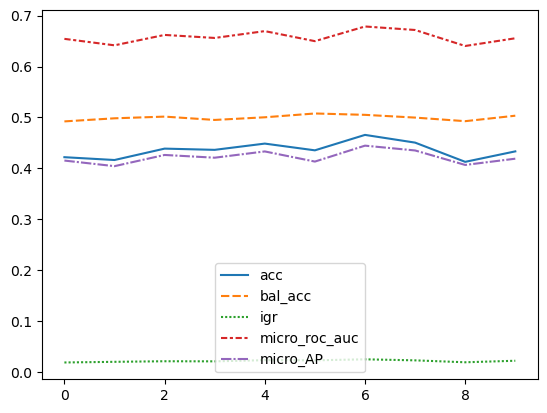

In [22]:
for i, (clust, cell_list) in enumerate(cell_clusters.items()): 
    print(clust)
    
    X_dict = {}
    y_dict = {}
    for _ct_big in cell_list: 
        metrics_dict = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
        print(_ct_big)
        
        for jj in range(0, 10): 
            if jj == 0: 
                DATA_FEATURE_SUB = DATA_FEATURE_NAMES.copy()
            X_dict = {}
            y_dict = {}
            for _ct in cell_list: 
                if _ct == _ct_big: 
                    X_test, y_test, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
                                                                      y_val=p_y_val, _testing_type="imbalanced", rna_type=p_rna_type, 
                                                                      data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
                    y_test += 1 # for 0, 1, 2, labels
                    X_test = aggregate_modalities(X_test, FEATURE_TYPES)
                    X_test = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
                else: 
                    X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
                                                                              y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                                              data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
                    y_balanced += 1 # for 0, 1, 2, labels
                    X = aggregate_modalities(X_balanced, FEATURE_TYPES)
                    X_dict[_ct] = X
                    y_dict[_ct] = y_balanced
    
            X_train, y_train = aggregate_cell_types(X_dict, y_dict, cell_list)
        
            X_train, y_train, kf = split(X_train, y_train, random_state=13)
            cols_to_use = X_train.columns.intersection(X_test.columns)
            X_train = X_train[cols_to_use]
            X_test = X_test[cols_to_use]

            print(y_train.value_counts())
            print(jj, ":", len(X_train.columns))
    
            # Training the actual model
            xgb_mod = train_model(X_train, y_train, objective, space, num_evals=num_evals)
    
            # Getting some evaluation metrics
            y_pred = xgb_mod.predict(X_test)
            y_score = xgb_mod.predict_proba(X_test)
            max_gain = information_gain(y_test, y_test)
            gain_ratio = information_gain(y_test, y_pred) / max_gain
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            micro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="micro")
            prec, rec, micro_AP = micro_PRC(y_test, y_score)

            metrics_dict['igr'].append(gain_ratio)
            metrics_dict['bal_acc'].append(bal_acc)
            metrics_dict['acc'].append(acc)
            metrics_dict['micro_roc_auc'].append(micro_roc_auc_ovr)
            metrics_dict['micro_AP'].append(micro_AP)
    
            print(_ct_big)
            print("IGR: %.3f; Balanced Accuracy: %.3f; Acuracy: %.3f; micro AP: %.3f; micro AUROC: %.3f" % (gain_ratio, bal_acc, acc, micro_AP, micro_roc_auc_ovr))

            with open(f'../result_data/xgb_mods/clust_mods/{clust}.{_ct_big}.{jj}.pkl', 'wb') as f: 
                pickle.dump(xgb_mod, f)

            if jj == 0: 
                df_feats = pd.DataFrame(X_train.columns).set_index(0)
                df_feats.index.name = "features"
                df_feats[f'epoch_{jj}'] = True
            else: 
                df_feats[f'epoch_{jj}'] = False
                df_feats.loc[X_train.columns, f'epoch_{jj}'] = True
            df_feats.to_csv(f"../result_data/xgb_mods/clust_features/{clust}.{_ct_big}.csv")

            # Getting the shap values
            explainer = shap.TreeExplainer(xgb_mod, X_test) # , feature_perturbation='interventional', model_output="predict_proba")
            shap_values = explainer(X_test, check_additivity=False)
            
            # Getting the next set of features
            ranked_order = rank_ordering_from_shap(shap_values, X_test)
            
            # downsampling 50% at a time
            ds = 0.5*len(X_train.columns)
            DATA_FEATURE_SUB = generate_ct_features(ranked_order, num_downsample=ds)
        df_metrics = pd.DataFrame.from_dict(metrics_dict)
        df_metrics.to_csv(f"../result_data/xgb_mods/clust_metrics/{clust}.{_ct_big}.metrics.csv")
        sns.lineplot(df_metrics)
        plt.show()

## Pick Model
Haven't done this yet and I am not so sure that I want to do this part (not neccessary imo)

In [32]:
for i, (clust, cell_list) in enumerate(cell_clusters.items()): 
    # print(clust)
    
    X_dict = {}
    y_dict = {}
    for _ct_big in cell_list: 
        # print(_ct_big)
        df_features = pd.read_csv(f"../result_data/xgb_mods/clust_features/{clust}.{_ct_big}.csv", index_col=0)
        df_metrics = pd.read_csv(f"../result_data/xgb_mods/clust_metrics/{clust}.{_ct_big}.metrics.csv", index_col=0)

        print(clust, _ct_big, df_metrics['acc'].max())
        # break
    # break

CTX_Glut L23_IT_CTX_Glut 0.5878327809259061
CTX_Glut L6_CT_CTX_Glut 0.6301838392475417
CTX_Glut L6_IT_CTX_Glut 0.6490867826650816
CTX_Glut L5_ET_CTX_Glut 0.5381683545682239
Hipo_Glut DG_Glut 0.569554753309266
Hipo_Glut CA1-ProS_Glut 0.5415388391213646
Hipo_Glut CA3_Glut 0.3067880603895355
NN Astro-TE_NN 0.549404133353447
NN Oligo_NN 0.6132347637937252
NN OPC_NN 0.4132462686567164
IT_CTX_Hipo_Glut L23_IT_CTX_Glut 0.5105313803057843
IT_CTX_Hipo_Glut L6_IT_CTX_Glut 0.6293094131632984
IT_CTX_Hipo_Glut CA1-ProS_Glut 0.6670757148116333
IT_CTX_Hipo_Glut CA3_Glut 0.5334793131266566
CTX_Hipo_Glut L23_IT_CTX_Glut 0.5317010584839089
CTX_Hipo_Glut L6_IT_CTX_Glut 0.6640008645844591
CTX_Hipo_Glut CA1-ProS_Glut 0.5863296109952142
CTX_Hipo_Glut CA3_Glut 0.5240290422957243
CTX_Hipo_Glut L6_CT_CTX_Glut 0.5970500213766566
CTX_Hipo_Glut L5_ET_CTX_Glut 0.6716759229010127
NN_DG_Glut Astro-TE_NN 0.5948106803439432
NN_DG_Glut Oligo_NN 0.6256761630003607
NN_DG_Glut OPC_NN 0.605410447761194
NN_DG_Glut DG_Glut 0

In [ ]:
# for _ct in cell_types: 
#     print(_ct)
            
#     X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES, 
#                                                               y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
#                                                              data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)

#     y_balanced += 1 # for 0, 1, 2, labels
#     X = aggregate_modalities(X_balanced, FEATURE_TYPES)

#     df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.cv.csv", index_col=0)
#     df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.cv.metrics.csv", index_col=0)
    
#     best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
#     # best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()

In [ ]:
# for i, (clust, cell_list) in enumerate(cell_clusters.items()): 
#     print(clust)
    
#     X_dict = {}
#     y_dict = {}
#     for _ct_big in cell_list: 
#         metrics_dict = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
#         print(_ct_big)
        
#         for jj in range(0, 10): 
#             if jj == 0: 
#                 DATA_FEATURE_SUB = DATA_FEATURE_NAMES.copy()
#             X_dict = {}
#             y_dict = {}
#             for _ct in cell_list: 
#                 if _ct == _ct_big: 
#                     X_test, y_test, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
#                                                                       y_val=p_y_val, _testing_type="imbalanced", rna_type=p_rna_type, 
#                                                                       data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
#                     y_test += 1 # for 0, 1, 2, labels
#                     X_test = aggregate_modalities(X_test, FEATURE_TYPES)
#                     X_test = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
#                 else: 
#                     X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
#                                                                               y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
#                                                                               data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
#                     y_balanced += 1 # for 0, 1, 2, labels
#                     X = aggregate_modalities(X_balanced, FEATURE_TYPES)
#                     X_dict[_ct] = X
#                     y_dict[_ct] = y_balanced
    
#             X_train, y_train = aggregate_cell_types(X_dict, y_dict, cell_list)
        
#             X_train, y_train, kf = split(X_train, y_train, random_state=13)
#             cols_to_use = X_train.columns.intersection(X_test.columns)
#             X_train = X_train[cols_to_use]
#             X_test = X_test[cols_to_use]

#             print(y_train.value_counts())
#             print(jj, ":", len(X_train.columns))
    
#             # Training the actual model
#             xgb_mod = train_model(X_train, y_train, objective, space, num_evals=num_evals)

In [ ]:
# for _ct in cell_types: 
#     print(_ct)
            
#     X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES, 
#                                                               y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
#                                                              data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)

#     y_balanced += 1 # for 0, 1, 2, labels
#     X = aggregate_modalities(X_balanced, FEATURE_TYPES)

#     df_features = pd.read_csv(f"../result_data/xgb_mods/celltype_features/{_ct}.cv.csv", index_col=0)
#     df_metrics = pd.read_csv(f"../result_data/xgb_mods/metric_img/{_ct}.cv.metrics.csv", index_col=0)
    
#     best_mod = df_metrics.rank(ascending=True).sum(axis=1).argmax()
#     # best_mod = df_metrics.rank(ascending=True)['bal_acc'].argmax()
    
#     with open(f"../result_data/xgb_mods/celltype_models/{_ct}.cv.{best_mod}.pkl", 'rb') as f: 
#         xgb_mod_loaded = pickle.load(f)
#     params = xgb_mod_loaded.get_xgb_params()
#     # Training a model based on the best hyperparameters 
#     xgb_mod = xgb.XGBClassifier(enable_categorical=False, max_depth=int(params['max_depth']), gamma=params['gamma'], 
#                                 n_estimators = int(xgb_mod_loaded.n_estimators), reg_alpha = int(params['reg_alpha']), 
#                                 reg_lambda = params['reg_lambda'], seed = 13)

#     X = X[xgb_mod_loaded.get_booster().feature_names].copy()
#     print(best_mod, ", num cols: ", X.shape[1])

#     Y_output = pd.DataFrame(y_balanced.copy())
#     Y_output['pred'] = -1
#     Y_output['score_0'] = -1.1
#     Y_output['score_1'] = -1.1
#     Y_output['score_2'] = -1.1

#     df_down_list = []; df_non_list = []; df_up_list = []
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
#     for i, (train_idx, test_idx) in enumerate(kf.split(X, y_balanced)): 
#         X_train = X.iloc[train_idx]
#         X_test = X.iloc[test_idx]
#         y_train = y_balanced.iloc[train_idx]
#         y_test = y_balanced.iloc[test_idx]
        
#         # sample_weights, sw_te = AK_sample_weights(y_train, y_test)
#         sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
        
#         xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)

#         y_pred = xgb_mod.predict(X_test)
#         y_score = xgb_mod.predict_proba(X_test)
#         Y_output.loc[y_test.index, 'pred'] = y_pred
#         Y_output.loc[y_test.index, 'score_0'] = y_score[:, 0]
#         Y_output.loc[y_test.index, 'score_1'] = y_score[:, 1]
#         Y_output.loc[y_test.index, 'score_2'] = y_score[:, 2]

#         print(accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred))

#         # Getting the shap values
#         explainer = shap.TreeExplainer(xgb_mod, X_test)
#         shap_values = explainer(X_test, check_additivity=False)
        
#         # Getting the inidividual dataframes and addint them to their lists
#         df_down, df_non, df_up = get_shap_dataframes(shap_values, X_test)
#         df_down_list.append(df_down)
#         df_non_list.append(df_non)
#         df_up_list.append(df_up)
#         # break

    
#     ccf_test = confusion_matrix(Y_output['DEG'], Y_output['pred'], normalize='true')
#     fig, ax = plt.subplots(1, 1)
#     sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
#                 square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)
#     ax.set_title(f"{_ct}")
#     plt.show()
    
#     df_down = pd.concat(df_down_list)
#     df_down.loc[Y_output.index, 'DEG'] = Y_output['DEG']
#     df_down.loc[Y_output.index, 'pred'] = Y_output['pred']
    
#     df_non = pd.concat(df_non_list)
#     df_non.loc[Y_output.index, 'DEG'] = Y_output['DEG']
#     df_non.loc[Y_output.index, 'pred'] = Y_output['pred']
    
#     df_up = pd.concat(df_up_list)
#     df_up.loc[Y_output.index, 'DEG'] = Y_output['DEG']
#     df_up.loc[Y_output.index, 'pred'] = Y_output['pred']


#     X.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.X.csv")
#     Y_output.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.Y_outs.csv")
#     df_down.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.shap_down.csv")
#     df_non.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.shap_non.csv")
#     df_up.to_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv_cs.shap_up.csv")

## Randomized Clusters
Generating Randomized Clusters (5 per cell type, and 4 cells within each randomized cluster).

Then training models on the randomized background samples to compare them to the ones trained on the correlation chosen clusters

In [36]:
cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Astro-TE_NN','Oligo_NN','OPC_NN',]

In [65]:
random_clusters = {}
for i, _ct in enumerate(cell_types): 
    random_clusters[_ct] = {}
    pool = [c for c in cell_types if c != _ct]
    for j in range(5): 
        bg_types = sample(pool, 4)
        random_clusters[_ct][j] = bg_types 

### run

In [79]:
# PARAMETERS
p_y_val = "DEG"
p_testing_type = "balanced_2"
p_rna_type = "luisa"
p_data_filepath = f"../data/v3"
p_na_cutoff=0.5
random_state = 13
SAMPLE_FEATURES = False
num_evals=10

L23_IT_CTX_Glut
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
0 : 205
100%|██████████| 10/10 [00:31<00:00,  3.17s/trial, best loss: -0.38424990693354344]
L23_IT_CTX_Glut
IGR: 0.030; Balanced Accuracy: 0.501; Acuracy: 0.497; micro AP: 0.475; micro AUROC: 0.726


100%|===================| 27953/28059 [01:12<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
1 : 153
100%|██████████| 10/10 [00:27<00:00,  2.75s/trial, best loss: -0.3833977929258396]
L23_IT_CTX_Glut
IGR: 0.027; Balanced Accuracy: 0.499; Acuracy: 0.502; micro AP: 0.475; micro AUROC: 0.725


100%|===================| 27985/28059 [01:18<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
2 : 124
100%|██████████| 10/10 [00:23<00:00,  2.33s/trial, best loss: -0.39241011603125775]
L23_IT_CTX_Glut
IGR: 0.024; Balanced Accuracy: 0.493; Acuracy: 0.511; micro AP: 0.486; micro AUROC: 0.727


 99%|===================| 27887/28059 [01:30<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
3 : 103
100%|██████████| 10/10 [00:19<00:00,  1.95s/trial, best loss: -0.3839965651912442]
L23_IT_CTX_Glut
IGR: 0.021; Balanced Accuracy: 0.486; Acuracy: 0.476; micro AP: 0.460; micro AUROC: 0.704


 99%|===================| 27854/28059 [00:58<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
4 : 82
100%|██████████| 10/10 [00:19<00:00,  1.99s/trial, best loss: -0.3832313444525527]
L23_IT_CTX_Glut
IGR: 0.021; Balanced Accuracy: 0.476; Acuracy: 0.557; micro AP: 0.544; micro AUROC: 0.764


100%|===================| 28018/28059 [01:50<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
5 : 64
100%|██████████| 10/10 [00:19<00:00,  1.92s/trial, best loss: -0.38799953058293013]
L23_IT_CTX_Glut
IGR: 0.017; Balanced Accuracy: 0.475; Acuracy: 0.528; micro AP: 0.496; micro AUROC: 0.730


 99%|===================| 27849/28059 [01:21<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
6 : 51
100%|██████████| 10/10 [00:13<00:00,  1.31s/trial, best loss: -0.38807068349296525]
L23_IT_CTX_Glut
IGR: 0.020; Balanced Accuracy: 0.483; Acuracy: 0.536; micro AP: 0.500; micro AUROC: 0.735


100%|===================| 27939/28059 [00:59<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
7 : 39
100%|██████████| 10/10 [00:09<00:00,  1.01trial/s, best loss: -0.3944839651624183]
L23_IT_CTX_Glut
IGR: 0.022; Balanced Accuracy: 0.488; Acuracy: 0.522; micro AP: 0.504; micro AUROC: 0.737


 98%|===================| 27631/28059 [01:03<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
8 : 33
100%|██████████| 10/10 [00:12<00:00,  1.26s/trial, best loss: -0.38982080639149314]
L23_IT_CTX_Glut
IGR: 0.028; Balanced Accuracy: 0.488; Acuracy: 0.537; micro AP: 0.512; micro AUROC: 0.748


100%|===================| 27959/28059 [01:54<00:00]        

zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
zero: 9063, non-zero: 190
zero: 4009, non-zero: 1537
9 : 28
100%|██████████| 10/10 [00:11<00:00,  1.16s/trial, best loss: -0.3921661333619556]
L23_IT_CTX_Glut
IGR: 0.022; Balanced Accuracy: 0.490; Acuracy: 0.508; micro AP: 0.466; micro AUROC: 0.713


 98%|===================| 27504/28059 [00:50<00:01]        

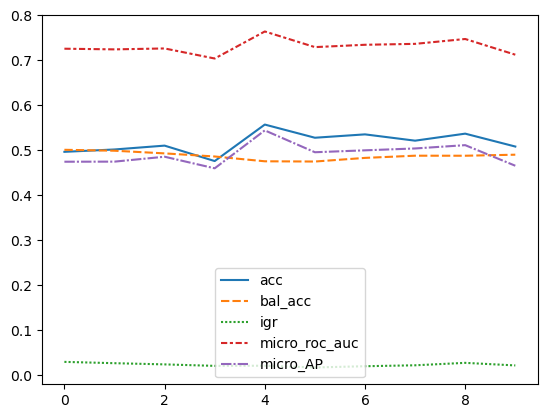

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
0 : 205
100%|██████████| 10/10 [00:34<00:00,  3.43s/trial, best loss: -0.3624664433553876]
L23_IT_CTX_Glut
IGR: 0.024; Balanced Accuracy: 0.500; Acuracy: 0.442; micro AP: 0.406; micro AUROC: 0.662


 98%|===================| 27633/28059 [01:02<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
1 : 148
100%|██████████| 10/10 [00:31<00:00,  3.13s/trial, best loss: -0.3711889028308827]
L23_IT_CTX_Glut
IGR: 0.023; Balanced Accuracy: 0.493; Acuracy: 0.431; micro AP: 0.400; micro AUROC: 0.653


 99%|===================| 27782/28059 [01:11<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
2 : 115
100%|██████████| 10/10 [00:24<00:00,  2.41s/trial, best loss: -0.3713067590300715]
L23_IT_CTX_Glut
IGR: 0.029; Balanced Accuracy: 0.506; Acuracy: 0.420; micro AP: 0.410; micro AUROC: 0.661


100%|===================| 28051/28059 [01:55<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
3 : 90
100%|██████████| 10/10 [00:23<00:00,  2.34s/trial, best loss: -0.368101794657831]
L23_IT_CTX_Glut
IGR: 0.023; Balanced Accuracy: 0.495; Acuracy: 0.455; micro AP: 0.425; micro AUROC: 0.678


 99%|===================| 27808/28059 [01:44<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
4 : 67
100%|██████████| 10/10 [00:16<00:00,  1.64s/trial, best loss: -0.37352675336402974]
L23_IT_CTX_Glut
IGR: 0.029; Balanced Accuracy: 0.504; Acuracy: 0.506; micro AP: 0.476; micro AUROC: 0.722


100%|===================| 27929/28059 [02:48<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
5 : 54
100%|██████████| 10/10 [00:18<00:00,  1.83s/trial, best loss: -0.3746801710055066]
L23_IT_CTX_Glut
IGR: 0.026; Balanced Accuracy: 0.495; Acuracy: 0.421; micro AP: 0.408; micro AUROC: 0.658


 99%|===================| 27906/28059 [02:08<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
6 : 43
100%|██████████| 10/10 [00:13<00:00,  1.39s/trial, best loss: -0.37266770296726814]
L23_IT_CTX_Glut
IGR: 0.025; Balanced Accuracy: 0.485; Acuracy: 0.428; micro AP: 0.416; micro AUROC: 0.670


100%|===================| 27955/28059 [01:45<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
7 : 32
100%|██████████| 10/10 [00:13<00:00,  1.37s/trial, best loss: -0.3688901849705552]
L23_IT_CTX_Glut
IGR: 0.025; Balanced Accuracy: 0.487; Acuracy: 0.471; micro AP: 0.451; micro AUROC: 0.700


100%|===================| 27957/28059 [02:25<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
8 : 24
100%|██████████| 10/10 [00:12<00:00,  1.27s/trial, best loss: -0.3667912257286635]
L23_IT_CTX_Glut
IGR: 0.021; Balanced Accuracy: 0.476; Acuracy: 0.389; micro AP: 0.394; micro AUROC: 0.652


 99%|===================| 27879/28059 [01:57<00:00]        

zero: 5461, non-zero: 2849
zero: 4009, non-zero: 1537
zero: 8692, non-zero: 491
zero: 6930, non-zero: 1219
9 : 20
100%|██████████| 10/10 [00:12<00:00,  1.23s/trial, best loss: -0.3625530562657573]
L23_IT_CTX_Glut
IGR: 0.022; Balanced Accuracy: 0.482; Acuracy: 0.376; micro AP: 0.377; micro AUROC: 0.632


 99%|===================| 27845/28059 [01:21<00:00]        

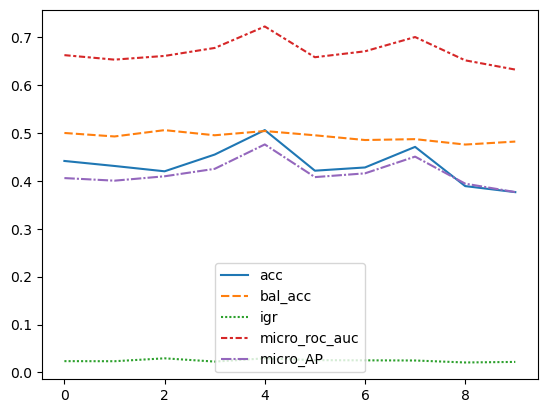

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
0 : 205
100%|██████████| 10/10 [00:28<00:00,  2.89s/trial, best loss: -0.4077120971278017]
L23_IT_CTX_Glut
IGR: 0.065; Balanced Accuracy: 0.549; Acuracy: 0.540; micro AP: 0.532; micro AUROC: 0.764


100%|===================| 28050/28059 [01:52<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
1 : 162
100%|██████████| 10/10 [00:25<00:00,  2.57s/trial, best loss: -0.416521389759977] 
L23_IT_CTX_Glut
IGR: 0.065; Balanced Accuracy: 0.557; Acuracy: 0.514; micro AP: 0.511; micro AUROC: 0.749


100%|===================| 27974/28059 [01:06<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
2 : 126
100%|██████████| 10/10 [00:25<00:00,  2.52s/trial, best loss: -0.40674245897421457]
L23_IT_CTX_Glut
IGR: 0.063; Balanced Accuracy: 0.542; Acuracy: 0.559; micro AP: 0.556; micro AUROC: 0.780


 99%|===================| 27797/28059 [01:22<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
3 : 99
100%|██████████| 10/10 [00:18<00:00,  1.86s/trial, best loss: -0.4202479031040502]
L23_IT_CTX_Glut
IGR: 0.064; Balanced Accuracy: 0.557; Acuracy: 0.540; micro AP: 0.528; micro AUROC: 0.764


 99%|===================| 27848/28059 [01:24<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
4 : 88
100%|██████████| 10/10 [00:19<00:00,  1.99s/trial, best loss: -0.41690969758738144]
L23_IT_CTX_Glut
IGR: 0.066; Balanced Accuracy: 0.559; Acuracy: 0.526; micro AP: 0.516; micro AUROC: 0.755


 99%|===================| 27712/28059 [00:56<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
5 : 71
100%|██████████| 10/10 [00:14<00:00,  1.45s/trial, best loss: -0.4240709058091149]
L23_IT_CTX_Glut
IGR: 0.069; Balanced Accuracy: 0.553; Acuracy: 0.572; micro AP: 0.564; micro AUROC: 0.786


 99%|===================| 27828/28059 [01:37<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
6 : 56
100%|██████████| 10/10 [00:12<00:00,  1.27s/trial, best loss: -0.40664758762390835]
L23_IT_CTX_Glut
IGR: 0.069; Balanced Accuracy: 0.570; Acuracy: 0.533; micro AP: 0.511; micro AUROC: 0.753


100%|===================| 28003/28059 [01:35<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
7 : 49
100%|██████████| 10/10 [00:11<00:00,  1.12s/trial, best loss: -0.4194032844682031]
L23_IT_CTX_Glut
IGR: 0.062; Balanced Accuracy: 0.559; Acuracy: 0.500; micro AP: 0.487; micro AUROC: 0.733


 99%|===================| 27878/28059 [00:48<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
8 : 43
100%|██████████| 10/10 [00:11<00:00,  1.17s/trial, best loss: -0.4238506690291122]
L23_IT_CTX_Glut
IGR: 0.070; Balanced Accuracy: 0.561; Acuracy: 0.540; micro AP: 0.523; micro AUROC: 0.757


100%|===================| 27967/28059 [01:41<00:00]        

zero: 4009, non-zero: 1537
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 8692, non-zero: 491
9 : 39
100%|██████████| 10/10 [00:10<00:00,  1.02s/trial, best loss: -0.42218324513204103]
L23_IT_CTX_Glut
IGR: 0.068; Balanced Accuracy: 0.565; Acuracy: 0.537; micro AP: 0.518; micro AUROC: 0.756


 99%|===================| 27843/28059 [01:39<00:00]        

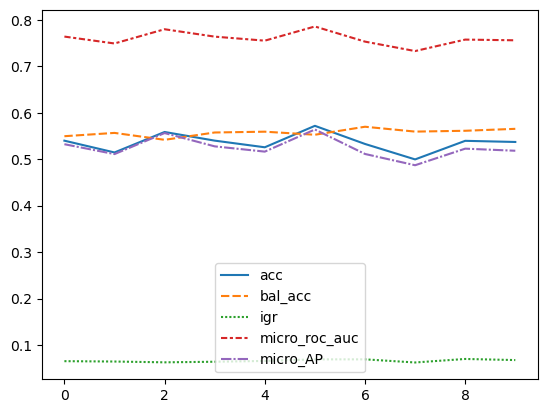

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
0 : 205
100%|██████████| 10/10 [00:32<00:00,  3.22s/trial, best loss: -0.36951930427812163]
L23_IT_CTX_Glut
IGR: 0.057; Balanced Accuracy: 0.518; Acuracy: 0.471; micro AP: 0.458; micro AUROC: 0.709


 99%|===================| 27891/28059 [02:06<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
1 : 158
100%|██████████| 10/10 [00:22<00:00,  2.26s/trial, best loss: -0.36678687894585843]
L23_IT_CTX_Glut
IGR: 0.054; Balanced Accuracy: 0.507; Acuracy: 0.457; micro AP: 0.447; micro AUROC: 0.702


100%|===================| 27990/28059 [01:39<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
2 : 126
100%|██████████| 10/10 [00:26<00:00,  2.63s/trial, best loss: -0.37543461460180955]
L23_IT_CTX_Glut
IGR: 0.054; Balanced Accuracy: 0.509; Acuracy: 0.490; micro AP: 0.471; micro AUROC: 0.722


 99%|===================| 27828/28059 [01:56<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
3 : 104
100%|██████████| 10/10 [00:21<00:00,  2.16s/trial, best loss: -0.3743473997991017]
L23_IT_CTX_Glut
IGR: 0.051; Balanced Accuracy: 0.509; Acuracy: 0.463; micro AP: 0.446; micro AUROC: 0.702


 99%|===================| 27713/28059 [00:54<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
4 : 84
100%|██████████| 10/10 [00:16<00:00,  1.65s/trial, best loss: -0.37882591315445174]
L23_IT_CTX_Glut
IGR: 0.055; Balanced Accuracy: 0.498; Acuracy: 0.480; micro AP: 0.463; micro AUROC: 0.716


100%|===================| 27925/28059 [01:49<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
5 : 70
100%|██████████| 10/10 [00:13<00:00,  1.36s/trial, best loss: -0.36683292377230836]
L23_IT_CTX_Glut
IGR: 0.049; Balanced Accuracy: 0.498; Acuracy: 0.457; micro AP: 0.444; micro AUROC: 0.701


100%|===================| 27973/28059 [01:07<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
6 : 58
100%|██████████| 10/10 [00:15<00:00,  1.59s/trial, best loss: -0.36947396953082395]
L23_IT_CTX_Glut
IGR: 0.053; Balanced Accuracy: 0.509; Acuracy: 0.492; micro AP: 0.483; micro AUROC: 0.729


100%|===================| 27980/28059 [01:58<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
7 : 49
100%|██████████| 10/10 [00:13<00:00,  1.33s/trial, best loss: -0.37237727960807565]
L23_IT_CTX_Glut
IGR: 0.051; Balanced Accuracy: 0.507; Acuracy: 0.456; micro AP: 0.456; micro AUROC: 0.708


100%|===================| 27968/28059 [01:16<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
8 : 43
100%|██████████| 10/10 [00:10<00:00,  1.07s/trial, best loss: -0.37459358252101504]
L23_IT_CTX_Glut
IGR: 0.054; Balanced Accuracy: 0.506; Acuracy: 0.481; micro AP: 0.466; micro AUROC: 0.718


100%|===================| 27991/28059 [01:38<00:00]        

zero: 7885, non-zero: 1471
zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 6930, non-zero: 1219
9 : 39
100%|██████████| 10/10 [00:12<00:00,  1.26s/trial, best loss: -0.37422252978938564]
L23_IT_CTX_Glut
IGR: 0.056; Balanced Accuracy: 0.516; Acuracy: 0.474; micro AP: 0.456; micro AUROC: 0.709


 99%|===================| 27838/28059 [01:45<00:00]        

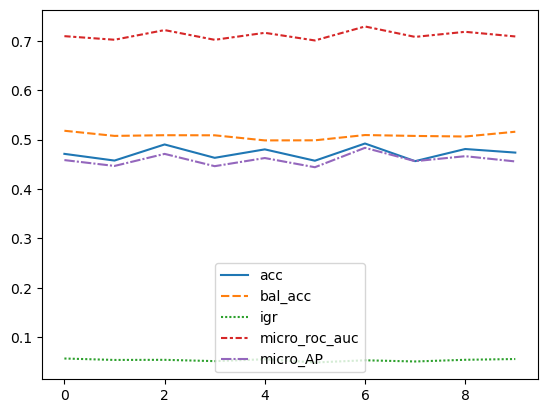

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
0 : 205
100%|██████████| 10/10 [00:34<00:00,  3.43s/trial, best loss: -0.37392094026846473]
L23_IT_CTX_Glut
IGR: 0.050; Balanced Accuracy: 0.519; Acuracy: 0.467; micro AP: 0.451; micro AUROC: 0.709


 99%|===================| 27747/28059 [01:14<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
1 : 163
100%|██████████| 10/10 [00:25<00:00,  2.55s/trial, best loss: -0.3758463251777585]
L23_IT_CTX_Glut
IGR: 0.044; Balanced Accuracy: 0.505; Acuracy: 0.493; micro AP: 0.475; micro AUROC: 0.727


 99%|===================| 27738/28059 [01:18<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
2 : 130
100%|██████████| 10/10 [00:27<00:00,  2.77s/trial, best loss: -0.3756856161181538]
L23_IT_CTX_Glut
IGR: 0.055; Balanced Accuracy: 0.522; Acuracy: 0.511; micro AP: 0.486; micro AUROC: 0.735


100%|===================| 28045/28059 [02:01<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
3 : 108
100%|██████████| 10/10 [00:28<00:00,  2.88s/trial, best loss: -0.3714841754412359]
L23_IT_CTX_Glut
IGR: 0.053; Balanced Accuracy: 0.521; Acuracy: 0.518; micro AP: 0.496; micro AUROC: 0.743


100%|===================| 27945/28059 [02:51<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
4 : 91
100%|██████████| 10/10 [00:21<00:00,  2.18s/trial, best loss: -0.3738324480474892]
L23_IT_CTX_Glut
IGR: 0.043; Balanced Accuracy: 0.501; Acuracy: 0.457; micro AP: 0.442; micro AUROC: 0.703


 99%|===================| 27721/28059 [01:14<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
5 : 76
100%|██████████| 10/10 [00:18<00:00,  1.90s/trial, best loss: -0.37326124564190166]
L23_IT_CTX_Glut
IGR: 0.050; Balanced Accuracy: 0.519; Acuracy: 0.492; micro AP: 0.472; micro AUROC: 0.724


100%|===================| 28039/28059 [02:29<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
6 : 67
100%|██████████| 10/10 [00:21<00:00,  2.14s/trial, best loss: -0.3701194698827946]
L23_IT_CTX_Glut
IGR: 0.044; Balanced Accuracy: 0.509; Acuracy: 0.465; micro AP: 0.449; micro AUROC: 0.709


100%|===================| 27945/28059 [01:43<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
7 : 60
100%|██████████| 10/10 [00:16<00:00,  1.69s/trial, best loss: -0.3736628116450822]
L23_IT_CTX_Glut
IGR: 0.047; Balanced Accuracy: 0.514; Acuracy: 0.515; micro AP: 0.491; micro AUROC: 0.740


 99%|===================| 27901/28059 [02:13<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
8 : 56
100%|██████████| 10/10 [00:16<00:00,  1.67s/trial, best loss: -0.3735574402948987]
L23_IT_CTX_Glut
IGR: 0.052; Balanced Accuracy: 0.525; Acuracy: 0.516; micro AP: 0.481; micro AUROC: 0.733


 99%|===================| 27736/28059 [01:24<00:00]        

zero: 6930, non-zero: 1219
zero: 7816, non-zero: 861
zero: 7885, non-zero: 1471
zero: 5461, non-zero: 2849
9 : 49
100%|██████████| 10/10 [00:17<00:00,  1.79s/trial, best loss: -0.37118156324866447]
L23_IT_CTX_Glut
IGR: 0.050; Balanced Accuracy: 0.517; Acuracy: 0.510; micro AP: 0.490; micro AUROC: 0.738


100%|===================| 27920/28059 [01:49<00:00]        

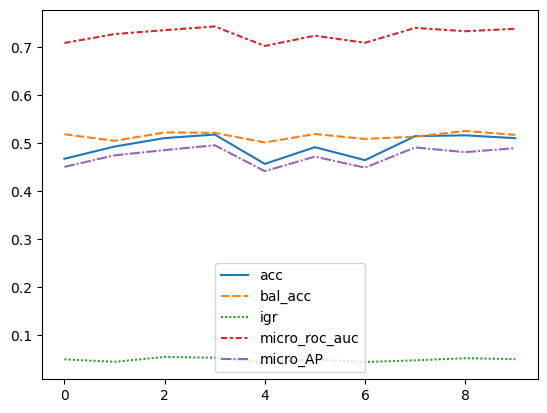

L5_ET_CTX_Glut
zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
0 : 189
100%|██████████| 10/10 [00:30<00:00,  3.08s/trial, best loss: 0.030005932923705302]
L5_ET_CTX_Glut
IGR: 0.033; Balanced Accuracy: 0.502; Acuracy: 0.547; micro AP: 0.504; micro AUROC: 0.735


100%|===================| 27490/27549 [00:53<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
1 : 145
100%|██████████| 10/10 [00:27<00:00,  2.77s/trial, best loss: 0.023365431249002498]
L5_ET_CTX_Glut
IGR: 0.030; Balanced Accuracy: 0.500; Acuracy: 0.541; micro AP: 0.499; micro AUROC: 0.734


 99%|===================| 27405/27549 [01:36<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
2 : 118
100%|██████████| 10/10 [00:23<00:00,  2.37s/trial, best loss: 0.03184810191369129]
L5_ET_CTX_Glut
IGR: 0.027; Balanced Accuracy: 0.499; Acuracy: 0.591; micro AP: 0.568; micro AUROC: 0.768


 99%|===================| 27388/27549 [01:17<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
3 : 93
100%|██████████| 10/10 [00:19<00:00,  1.93s/trial, best loss: 0.024982081569370384]
L5_ET_CTX_Glut
IGR: 0.032; Balanced Accuracy: 0.492; Acuracy: 0.586; micro AP: 0.538; micro AUROC: 0.744


 99%|===================| 27404/27549 [01:25<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
4 : 74
100%|██████████| 10/10 [00:19<00:00,  1.93s/trial, best loss: 0.03586067754911397]
L5_ET_CTX_Glut
IGR: 0.027; Balanced Accuracy: 0.493; Acuracy: 0.565; micro AP: 0.542; micro AUROC: 0.754


 99%|===================| 27282/27549 [01:16<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
5 : 59
100%|██████████| 10/10 [00:12<00:00,  1.26s/trial, best loss: 0.042270241194177306]
L5_ET_CTX_Glut
IGR: 0.029; Balanced Accuracy: 0.500; Acuracy: 0.542; micro AP: 0.507; micro AUROC: 0.738


100%|===================| 27528/27549 [01:04<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
6 : 48
100%|██████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: 0.04255875954014502]
L5_ET_CTX_Glut
IGR: 0.034; Balanced Accuracy: 0.522; Acuracy: 0.534; micro AP: 0.482; micro AUROC: 0.734


 99%|===================| 27156/27549 [00:43<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
7 : 42
100%|██████████| 10/10 [00:12<00:00,  1.24s/trial, best loss: 0.02609789354004516]
L5_ET_CTX_Glut
IGR: 0.035; Balanced Accuracy: 0.508; Acuracy: 0.561; micro AP: 0.557; micro AUROC: 0.760


100%|===================| 27530/27549 [01:41<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
8 : 36
100%|██████████| 10/10 [00:11<00:00,  1.10s/trial, best loss: 0.03085128066055377]
L5_ET_CTX_Glut
IGR: 0.026; Balanced Accuracy: 0.503; Acuracy: 0.538; micro AP: 0.526; micro AUROC: 0.744


 99%|===================| 27394/27549 [01:19<00:00]        

zero: 9063, non-zero: 190
zero: 6930, non-zero: 1219
zero: 5461, non-zero: 2849
zero: 6436, non-zero: 193
9 : 30
100%|██████████| 10/10 [00:09<00:00,  1.01trial/s, best loss: 0.040273224645433994]
L5_ET_CTX_Glut
IGR: 0.030; Balanced Accuracy: 0.513; Acuracy: 0.522; micro AP: 0.490; micro AUROC: 0.717


 99%|===================| 27398/27549 [01:01<00:00]        

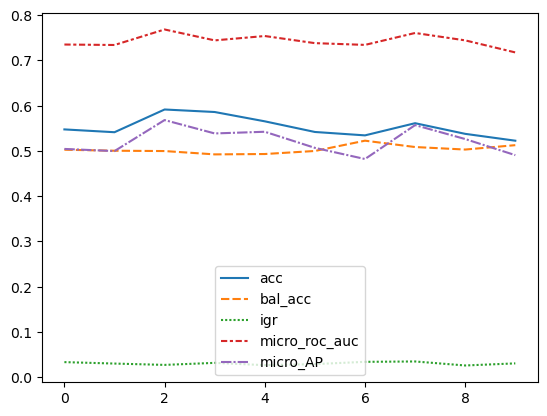

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
0 : 195
100%|██████████| 10/10 [00:27<00:00,  2.74s/trial, best loss: 0.056620914677488254]
L5_ET_CTX_Glut
IGR: 0.047; Balanced Accuracy: 0.539; Acuracy: 0.517; micro AP: 0.497; micro AUROC: 0.751


100%|===================| 27482/27549 [00:58<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
1 : 155
100%|██████████| 10/10 [00:25<00:00,  2.56s/trial, best loss: 0.05409116133741173]
L5_ET_CTX_Glut
IGR: 0.044; Balanced Accuracy: 0.525; Acuracy: 0.614; micro AP: 0.613; micro AUROC: 0.813


 99%|===================| 27173/27549 [01:03<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
2 : 128
100%|██████████| 10/10 [00:22<00:00,  2.23s/trial, best loss: 0.049382051573984474]
L5_ET_CTX_Glut
IGR: 0.045; Balanced Accuracy: 0.519; Acuracy: 0.581; micro AP: 0.562; micro AUROC: 0.791


 99%|===================| 27340/27549 [01:33<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
3 : 105
100%|██████████| 10/10 [00:18<00:00,  1.88s/trial, best loss: 0.055308641133923454]
L5_ET_CTX_Glut
IGR: 0.043; Balanced Accuracy: 0.534; Acuracy: 0.623; micro AP: 0.632; micro AUROC: 0.827


 99%|===================| 27314/27549 [01:00<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
4 : 90
100%|██████████| 10/10 [00:15<00:00,  1.59s/trial, best loss: 0.05562759863008605]
L5_ET_CTX_Glut
IGR: 0.053; Balanced Accuracy: 0.541; Acuracy: 0.600; micro AP: 0.593; micro AUROC: 0.806


100%|===================| 27439/27549 [01:41<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
5 : 73
100%|██████████| 10/10 [00:15<00:00,  1.51s/trial, best loss: 0.0468651100031222]
L5_ET_CTX_Glut
IGR: 0.054; Balanced Accuracy: 0.543; Acuracy: 0.563; micro AP: 0.528; micro AUROC: 0.777


 99%|===================| 27277/27549 [00:49<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
6 : 63
100%|██████████| 10/10 [00:13<00:00,  1.32s/trial, best loss: 0.048106422893804124]
L5_ET_CTX_Glut
IGR: 0.041; Balanced Accuracy: 0.512; Acuracy: 0.664; micro AP: 0.678; micro AUROC: 0.846


100%|===================| 27461/27549 [02:09<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
7 : 56
100%|██████████| 10/10 [00:11<00:00,  1.10s/trial, best loss: 0.05517209804142228]
L5_ET_CTX_Glut
IGR: 0.040; Balanced Accuracy: 0.516; Acuracy: 0.487; micro AP: 0.464; micro AUROC: 0.724


 99%|===================| 27395/27549 [00:52<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
8 : 48
100%|██████████| 10/10 [00:12<00:00,  1.21s/trial, best loss: 0.06632375668089037]
L5_ET_CTX_Glut
IGR: 0.046; Balanced Accuracy: 0.527; Acuracy: 0.531; micro AP: 0.490; micro AUROC: 0.752


 98%|===================| 27017/27549 [00:44<00:00]        

zero: 7816, non-zero: 861
zero: 6930, non-zero: 1219
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
9 : 41
100%|██████████| 10/10 [00:10<00:00,  1.09s/trial, best loss: 0.05939789819912724]
L5_ET_CTX_Glut
IGR: 0.053; Balanced Accuracy: 0.536; Acuracy: 0.567; micro AP: 0.541; micro AUROC: 0.782


 98%|===================| 27127/27549 [00:36<00:00]        

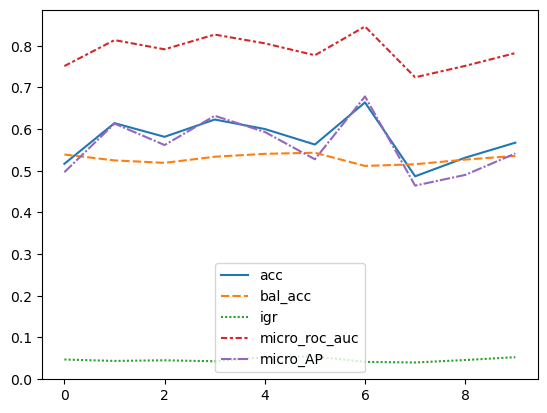

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
0 : 189
100%|██████████| 10/10 [00:33<00:00,  3.31s/trial, best loss: -0.024364004903328806]
L5_ET_CTX_Glut
IGR: 0.052; Balanced Accuracy: 0.595; Acuracy: 0.499; micro AP: 0.469; micro AUROC: 0.730


 99%|===================| 27153/27549 [00:52<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
1 : 147
100%|██████████| 10/10 [00:25<00:00,  2.57s/trial, best loss: -0.00894295064748144]
L5_ET_CTX_Glut
IGR: 0.040; Balanced Accuracy: 0.557; Acuracy: 0.498; micro AP: 0.468; micro AUROC: 0.732


 98%|===================| 27124/27549 [00:41<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
2 : 118
100%|██████████| 10/10 [00:20<00:00,  2.08s/trial, best loss: -0.014637758511540333]
L5_ET_CTX_Glut
IGR: 0.047; Balanced Accuracy: 0.553; Acuracy: 0.548; micro AP: 0.524; micro AUROC: 0.765


100%|===================| 27431/27549 [01:12<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
3 : 95
100%|██████████| 10/10 [00:17<00:00,  1.78s/trial, best loss: -0.003977763795688438]
L5_ET_CTX_Glut
IGR: 0.049; Balanced Accuracy: 0.577; Acuracy: 0.512; micro AP: 0.481; micro AUROC: 0.740


100%|===================| 27462/27549 [01:02<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
4 : 80
100%|██████████| 10/10 [00:16<00:00,  1.69s/trial, best loss: -0.012509257359296599]
L5_ET_CTX_Glut
IGR: 0.048; Balanced Accuracy: 0.569; Acuracy: 0.564; micro AP: 0.505; micro AUROC: 0.765


 99%|===================| 27268/27549 [00:56<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
5 : 64
100%|██████████| 10/10 [00:14<00:00,  1.46s/trial, best loss: -0.02925675501566858]
L5_ET_CTX_Glut
IGR: 0.044; Balanced Accuracy: 0.550; Acuracy: 0.553; micro AP: 0.533; micro AUROC: 0.770


100%|===================| 27474/27549 [02:26<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
6 : 54
100%|██████████| 10/10 [00:14<00:00,  1.42s/trial, best loss: -0.01714661480855405]
L5_ET_CTX_Glut
IGR: 0.042; Balanced Accuracy: 0.544; Acuracy: 0.545; micro AP: 0.536; micro AUROC: 0.768


 99%|===================| 27374/27549 [02:03<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
7 : 43
100%|██████████| 10/10 [00:11<00:00,  1.10s/trial, best loss: -0.012357377090854493]
L5_ET_CTX_Glut
IGR: 0.050; Balanced Accuracy: 0.574; Acuracy: 0.511; micro AP: 0.486; micro AUROC: 0.739


 99%|===================| 27206/27549 [01:19<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
8 : 38
100%|██████████| 10/10 [00:09<00:00,  1.05trial/s, best loss: -0.0060086311923363885]
L5_ET_CTX_Glut
IGR: 0.057; Balanced Accuracy: 0.590; Acuracy: 0.509; micro AP: 0.482; micro AUROC: 0.743


 99%|===================| 27410/27549 [00:53<00:00]        

zero: 6436, non-zero: 193
zero: 4009, non-zero: 1537
zero: 7789, non-zero: 1564
zero: 6262, non-zero: 170
9 : 35
100%|██████████| 10/10 [00:10<00:00,  1.02s/trial, best loss: -0.00825725123037696]
L5_ET_CTX_Glut
IGR: 0.045; Balanced Accuracy: 0.549; Acuracy: 0.520; micro AP: 0.488; micro AUROC: 0.746


 99%|===================| 27349/27549 [01:27<00:00]        

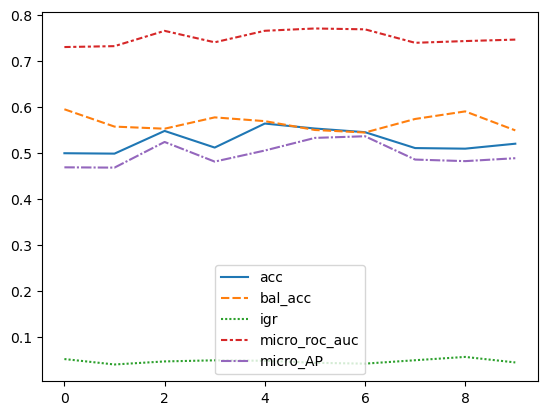

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
0 : 195
100%|██████████| 10/10 [00:35<00:00,  3.57s/trial, best loss: 0.023797980773013816]
L5_ET_CTX_Glut
IGR: 0.035; Balanced Accuracy: 0.529; Acuracy: 0.493; micro AP: 0.442; micro AUROC: 0.706


 99%|===================| 27261/27549 [01:21<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
1 : 148
100%|██████████| 10/10 [00:32<00:00,  3.27s/trial, best loss: 0.022452440458761668]
L5_ET_CTX_Glut
IGR: 0.038; Balanced Accuracy: 0.526; Acuracy: 0.493; micro AP: 0.456; micro AUROC: 0.717


100%|===================| 27466/27549 [01:58<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
2 : 119
100%|██████████| 10/10 [00:24<00:00,  2.46s/trial, best loss: 0.022154449510505558]
L5_ET_CTX_Glut
IGR: 0.036; Balanced Accuracy: 0.527; Acuracy: 0.498; micro AP: 0.454; micro AUROC: 0.712


100%|===================| 27546/27549 [01:17<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
3 : 96
100%|██████████| 10/10 [00:18<00:00,  1.80s/trial, best loss: 0.018573714161026877]
L5_ET_CTX_Glut
IGR: 0.029; Balanced Accuracy: 0.503; Acuracy: 0.515; micro AP: 0.478; micro AUROC: 0.728


100%|===================| 27475/27549 [01:08<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
4 : 80
100%|██████████| 10/10 [00:17<00:00,  1.78s/trial, best loss: 0.026681503023017306]
L5_ET_CTX_Glut
IGR: 0.033; Balanced Accuracy: 0.505; Acuracy: 0.412; micro AP: 0.387; micro AUROC: 0.647


100%|===================| 27433/27549 [00:49<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
5 : 67
100%|██████████| 10/10 [00:15<00:00,  1.52s/trial, best loss: 0.024311762323501497]
L5_ET_CTX_Glut
IGR: 0.034; Balanced Accuracy: 0.522; Acuracy: 0.419; micro AP: 0.400; micro AUROC: 0.660


100%|===================| 27541/27549 [02:03<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
6 : 56
100%|██████████| 10/10 [00:17<00:00,  1.74s/trial, best loss: 0.013635872577851649]
L5_ET_CTX_Glut
IGR: 0.042; Balanced Accuracy: 0.535; Acuracy: 0.483; micro AP: 0.438; micro AUROC: 0.699


 99%|===================| 27358/27549 [01:27<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
7 : 52
100%|██████████| 10/10 [00:16<00:00,  1.63s/trial, best loss: 0.013771408293789955]
L5_ET_CTX_Glut
IGR: 0.035; Balanced Accuracy: 0.526; Acuracy: 0.495; micro AP: 0.459; micro AUROC: 0.710


100%|===================| 27448/27549 [02:27<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
8 : 44
100%|██████████| 10/10 [00:14<00:00,  1.47s/trial, best loss: 0.01818332811873542]
L5_ET_CTX_Glut
IGR: 0.034; Balanced Accuracy: 0.533; Acuracy: 0.495; micro AP: 0.458; micro AUROC: 0.715


100%|===================| 27521/27549 [01:19<00:00]        

zero: 7816, non-zero: 861
zero: 6436, non-zero: 193
zero: 7789, non-zero: 1564
zero: 5461, non-zero: 2849
9 : 36
100%|██████████| 10/10 [00:12<00:00,  1.23s/trial, best loss: 0.023022110103291492]
L5_ET_CTX_Glut
IGR: 0.032; Balanced Accuracy: 0.517; Acuracy: 0.437; micro AP: 0.408; micro AUROC: 0.667


100%|===================| 27498/27549 [01:54<00:00]        

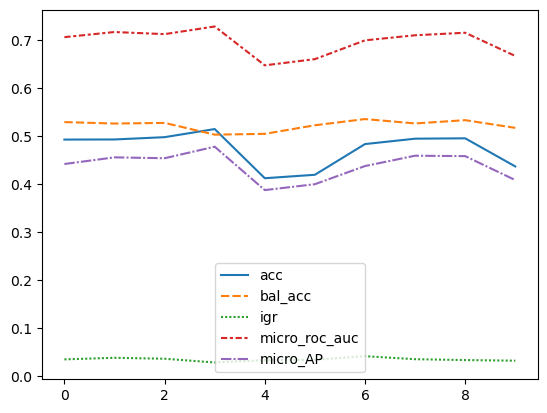

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
0 : 195
100%|██████████| 10/10 [00:37<00:00,  3.71s/trial, best loss: -0.006980157239053741]
L5_ET_CTX_Glut
IGR: 0.058; Balanced Accuracy: 0.534; Acuracy: 0.604; micro AP: 0.583; micro AUROC: 0.795


100%|===================| 27544/27549 [01:36<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
1 : 151
100%|██████████| 10/10 [00:28<00:00,  2.82s/trial, best loss: 0.009554637703509828]
L5_ET_CTX_Glut
IGR: 0.049; Balanced Accuracy: 0.522; Acuracy: 0.657; micro AP: 0.630; micro AUROC: 0.831


 99%|===================| 27344/27549 [01:17<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
2 : 123
100%|██████████| 10/10 [00:25<00:00,  2.57s/trial, best loss: -0.010685302189620527]
L5_ET_CTX_Glut
IGR: 0.062; Balanced Accuracy: 0.538; Acuracy: 0.670; micro AP: 0.651; micro AUROC: 0.841


100%|===================| 27484/27549 [02:05<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
3 : 106
100%|██████████| 10/10 [00:21<00:00,  2.19s/trial, best loss: -0.018535679703504903]
L5_ET_CTX_Glut
IGR: 0.054; Balanced Accuracy: 0.526; Acuracy: 0.655; micro AP: 0.650; micro AUROC: 0.833


100%|===================| 27511/27549 [02:25<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
4 : 84
100%|██████████| 10/10 [00:17<00:00,  1.78s/trial, best loss: 0.0028170878259704546]
L5_ET_CTX_Glut
IGR: 0.063; Balanced Accuracy: 0.552; Acuracy: 0.637; micro AP: 0.596; micro AUROC: 0.816


100%|===================| 27535/27549 [01:39<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
5 : 72
100%|██████████| 10/10 [00:13<00:00,  1.39s/trial, best loss: 0.0032312425391842316]
L5_ET_CTX_Glut
IGR: 0.066; Balanced Accuracy: 0.564; Acuracy: 0.577; micro AP: 0.529; micro AUROC: 0.770


 99%|===================| 27306/27549 [01:04<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
6 : 60
100%|██████████| 10/10 [00:13<00:00,  1.35s/trial, best loss: 0.008853849442609484]
L5_ET_CTX_Glut
IGR: 0.056; Balanced Accuracy: 0.524; Acuracy: 0.611; micro AP: 0.581; micro AUROC: 0.796


 99%|===================| 27310/27549 [01:31<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
7 : 56
100%|██████████| 10/10 [00:13<00:00,  1.36s/trial, best loss: -0.009595043779491098]
L5_ET_CTX_Glut
IGR: 0.056; Balanced Accuracy: 0.529; Acuracy: 0.610; micro AP: 0.569; micro AUROC: 0.792


100%|===================| 27507/27549 [01:44<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
8 : 50
100%|██████████| 10/10 [00:13<00:00,  1.30s/trial, best loss: 0.003618592849342339]
L5_ET_CTX_Glut
IGR: 0.049; Balanced Accuracy: 0.527; Acuracy: 0.592; micro AP: 0.567; micro AUROC: 0.784


100%|===================| 27488/27549 [02:32<00:00]        

zero: 7816, non-zero: 861
zero: 9063, non-zero: 190
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
9 : 47
100%|██████████| 10/10 [00:12<00:00,  1.20s/trial, best loss: -0.0007427597649694806]
L5_ET_CTX_Glut
IGR: 0.043; Balanced Accuracy: 0.494; Acuracy: 0.628; micro AP: 0.636; micro AUROC: 0.819


100%|===================| 27517/27549 [02:19<00:00]        

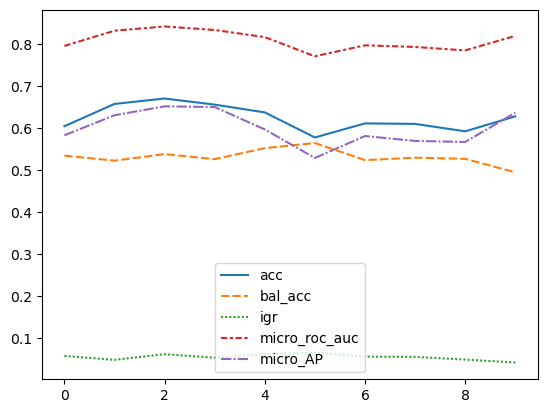

L6_IT_CTX_Glut
zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
0 : 205
100%|██████████| 10/10 [00:34<00:00,  3.41s/trial, best loss: 0.7527745229882514]
L6_IT_CTX_Glut
IGR: 0.074; Balanced Accuracy: 0.633; Acuracy: 0.585; micro AP: 0.537; micro AUROC: 0.784


100%|===================| 27755/27759 [01:10<00:00]        

zero: 7885, non-zero: 1471
zero: 4009, non-zero: 1537
zero: 6262, non-zero: 170
zero: 5461, non-zero: 2849
1 : 159
 80%|████████  | 8/10 [00:33<00:08,  4.39s/trial, best loss: 0.7592302451860248]

In [ ]:
# Iterating over all cell types
for i, (_ct_big, cluster_dict) in enumerate(random_clusters.items()): 
    print(_ct_big)
    # Iterating over all random clusters for a given cell type
    for k, cell_list in cluster_dict.items(): 
        metrics_dict = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
        # For iteratively downsampling the feature list
        for jj in range(0, 10): 
            if jj == 0: 
                DATA_FEATURE_SUB = DATA_FEATURE_NAMES.copy()
            # getting the test set for the given big celltype
            X_test, y_test, FEATURE_TYPES = load_data_wrapper(_ct_big, DATA_FEATURE_SUB, 
                                                              y_val=p_y_val, _testing_type="imbalanced", rna_type=p_rna_type, 
                                                              data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
            y_test += 1 # for 0, 1, 2, labels
            X_test = aggregate_modalities(X_test, FEATURE_TYPES)
            X_test = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
            
            # Iterating over all train set celltypes
            X_dict = {}
            y_dict = {}
            for _ct in cell_list: 
                X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
                                                                          y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                                          data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
                y_balanced += 1 # for 0, 1, 2, labels
                X = aggregate_modalities(X_balanced, FEATURE_TYPES)
                X_dict[_ct] = X
                y_dict[_ct] = y_balanced
            # Getting the training set by aggregating the cell types 
            X_train, y_train = aggregate_cell_types(X_dict, y_dict, cell_list)
            # Generating the splits and making sure the column sets are equal
            X_train, y_train, kf = split(X_train, y_train, random_state=13)
            cols_to_use = X_train.columns.intersection(X_test.columns)
            X_train = X_train[cols_to_use]
            X_test = X_test[cols_to_use]
            
            # print(y_train.value_counts())
            print(jj, ":", len(X_train.columns))
            
            # Training the actual model
            xgb_mod = train_model(X_train, y_train, objective, space, num_evals=num_evals)
    
            # Getting some evaluation metrics
            y_pred = xgb_mod.predict(X_test)
            y_score = xgb_mod.predict_proba(X_test)
            max_gain = information_gain(y_test, y_test)
            gain_ratio = information_gain(y_test, y_pred) / max_gain
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            micro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="micro")
            prec, rec, micro_AP = micro_PRC(y_test, y_score)

            metrics_dict['igr'].append(gain_ratio)
            metrics_dict['bal_acc'].append(bal_acc)
            metrics_dict['acc'].append(acc)
            metrics_dict['micro_roc_auc'].append(micro_roc_auc_ovr)
            metrics_dict['micro_AP'].append(micro_AP)
    
            print(_ct_big)
            print("IGR: %.3f; Balanced Accuracy: %.3f; Acuracy: %.3f; micro AP: %.3f; micro AUROC: %.3f" % (gain_ratio, bal_acc, acc, micro_AP, micro_roc_auc_ovr))

            # Getting the shap values
            explainer = shap.TreeExplainer(xgb_mod, X_test) # , feature_perturbation='interventional', model_output="predict_proba")
            shap_values = explainer(X_test, check_additivity=False)
            
            # Getting the next set of features
            ranked_order = rank_ordering_from_shap(shap_values, X_test)
            
            # downsampling 50% at a time
            ds = 0.5*len(X_train.columns)
            DATA_FEATURE_SUB = generate_ct_features(ranked_order, num_downsample=ds)
            
        df_metrics = pd.DataFrame.from_dict(metrics_dict)
        df_metrics.to_csv(f"../result_data/xgb_mods/clust_rand_metrics/{_ct_big}.rand_{k}.metrics.csv")
        sns.lineplot(df_metrics)
        plt.show()

In [ ]:
for i, (clust, cell_list) in enumerate(cell_clusters.items()): 
    print(clust)
    
    X_dict = {}
    y_dict = {}
    for _ct_big in cell_list: 
        metrics_dict = {'acc' : [],  'bal_acc' : [], 'igr' : [], 'micro_roc_auc' : [], 'micro_AP' : []}
        print(_ct_big)
        
        for jj in range(0, 10): 
            if jj == 0: 
                DATA_FEATURE_SUB = DATA_FEATURE_NAMES.copy()
            X_dict = {}
            y_dict = {}
            for _ct in cell_list: 
                if _ct == _ct_big: 
                    X_test, y_test, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
                                                                      y_val=p_y_val, _testing_type="imbalanced", rna_type=p_rna_type, 
                                                                      data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
                    y_test += 1 # for 0, 1, 2, labels
                    X_test = aggregate_modalities(X_test, FEATURE_TYPES)
                    X_test = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
                else: 
                    X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_SUB, 
                                                                              y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                                              data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
                    y_balanced += 1 # for 0, 1, 2, labels
                    X = aggregate_modalities(X_balanced, FEATURE_TYPES)
                    X_dict[_ct] = X
                    y_dict[_ct] = y_balanced
    
            X_train, y_train = aggregate_cell_types(X_dict, y_dict, cell_list)
        
            X_train, y_train, kf = split(X_train, y_train, random_state=13)
            cols_to_use = X_train.columns.intersection(X_test.columns)
            X_train = X_train[cols_to_use]
            X_test = X_test[cols_to_use]

            print(y_train.value_counts())
            print(jj, ":", len(X_train.columns))
    
            # Training the actual model
            xgb_mod = train_model(X_train, y_train, objective, space, num_evals=num_evals)
    
            # Getting some evaluation metrics
            y_pred = xgb_mod.predict(X_test)
            y_score = xgb_mod.predict_proba(X_test)
            max_gain = information_gain(y_test, y_test)
            gain_ratio = information_gain(y_test, y_pred) / max_gain
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            micro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="micro")
            prec, rec, micro_AP = micro_PRC(y_test, y_score)

            metrics_dict['igr'].append(gain_ratio)
            metrics_dict['bal_acc'].append(bal_acc)
            metrics_dict['acc'].append(acc)
            metrics_dict['micro_roc_auc'].append(micro_roc_auc_ovr)
            metrics_dict['micro_AP'].append(micro_AP)
    
            print(_ct_big)
            print("IGR: %.3f; Balanced Accuracy: %.3f; Acuracy: %.3f; micro AP: %.3f; micro AUROC: %.3f" % (gain_ratio, bal_acc, acc, micro_AP, micro_roc_auc_ovr))

            with open(f'../result_data/xgb_mods/clust_mods/{clust}.{_ct_big}.{jj}.pkl', 'wb') as f: 
                pickle.dump(xgb_mod, f)

            if jj == 0: 
                df_feats = pd.DataFrame(X_train.columns).set_index(0)
                df_feats.index.name = "features"
                df_feats[f'epoch_{jj}'] = True
            else: 
                df_feats[f'epoch_{jj}'] = False
                df_feats.loc[X_train.columns, f'epoch_{jj}'] = True
            df_feats.to_csv(f"../result_data/xgb_mods/clust_features/{clust}.{_ct_big}.csv")

            # Getting the shap values
            explainer = shap.TreeExplainer(xgb_mod, X_test) # , feature_perturbation='interventional', model_output="predict_proba")
            shap_values = explainer(X_test, check_additivity=False)
            
            # Getting the next set of features
            ranked_order = rank_ordering_from_shap(shap_values, X_test)
            
            # downsampling 50% at a time
            ds = 0.5*len(X_train.columns)
            DATA_FEATURE_SUB = generate_ct_features(ranked_order, num_downsample=ds)
        df_metrics = pd.DataFrame.from_dict(metrics_dict)
        df_metrics.to_csv(f"../result_data/xgb_mods/clust_metrics/{clust}.{_ct_big}.metrics.csv")
        sns.lineplot(df_metrics)
        plt.show()